#  PRÉDICTION ÉMISSIONS GES - BÂTIMENTS SEATTLE
## Notebook 04 : Modélisation Complète avec Pipelines

---

###  Informations

**Dataset** : 1,666 bâtiments (2015-2016)  
**Objectif** : Comparer 2 approches prédictives  
**Date** : Janvier 2026

###  Les 2 Modèles

1. **Modèle 1** : Variables disponibles au permis (sans ENERGY STAR)
2. **Modèle 2** : Avec ENERGY STAR Score

---

# Section 0 : Configuration et Imports

In [3]:
# ============================================================================
# IMPORTS STANDARDS
# ============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')
import importlib.util
from datetime import datetime
import time
import importlib.util

# ============================================================================
# CONFIGURATION CHEMINS - VERSION RELATIVE
# ============================================================================

from pathlib import Path
import os

# Obtenir le répertoire du notebook actuel
NOTEBOOK_DIR = Path.cwd()

# Remonter d'un niveau pour accéder au répertoire racine du projet
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Vérifier que le projet existe
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"❌ Le projet n'existe pas à : {PROJECT_ROOT}")

SRC_PATH = PROJECT_ROOT / 'src'

if not SRC_PATH.exists():
    raise FileNotFoundError(f"❌ Le dossier src n'existe pas à : {SRC_PATH}")

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✓ PROJECT_ROOT : {PROJECT_ROOT}")
print(f"✓ SRC_PATH : {SRC_PATH}")
print(f"✓ Chemins configurés")

✓ PROJECT_ROOT : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3
✓ SRC_PATH : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\src
✓ Chemins configurés


In [ ]:
# ============================================================================
# IMPORTS MODULES PERSONNALISÉS
# ============================================================================

# modeling_utils
spec_modeling = importlib.util.spec_from_file_location("modeling_utils", SRC_PATH / "modeling_utils.py")
modeling_utils = importlib.util.module_from_spec(spec_modeling)
spec_modeling.loader.exec_module(modeling_utils)

# evaluation_utils
spec_eval = importlib.util.spec_from_file_location("evaluation_utils", SRC_PATH / "evaluation_utils.py")
evaluation_utils = importlib.util.module_from_spec(spec_eval)
spec_eval.loader.exec_module(evaluation_utils)

# visualization_utils
spec_viz = importlib.util.spec_from_file_location("visualization_utils", SRC_PATH / "visualization_utils.py")
visualization_utils = importlib.util.module_from_spec(spec_viz)
spec_viz.loader.exec_module(visualization_utils)

# Extraire fonctions
train_multiple_models = modeling_utils.train_multiple_models
save_model = modeling_utils.save_model
get_feature_importance = modeling_utils.get_feature_importance
compare_models = modeling_utils.compare_models

evaluate_model = evaluation_utils.evaluate_model
cv_evaluate_model = evaluation_utils.cv_evaluate_model
compute_residuals_stats = evaluation_utils.compute_residuals_stats
calculate_metrics_summary = evaluation_utils.calculate_metrics_summary
compare_model_performance = evaluation_utils.compare_model_performance

plot_predictions = visualization_utils.plot_predictions
plot_residuals_distribution = visualization_utils.plot_residuals_distribution
plot_feature_importance = visualization_utils.plot_feature_importance
plot_model_comparison = visualization_utils.plot_model_comparison
plot_comparison_two_models = visualization_utils.plot_comparison_two_models

print("✓ Modules personnalisés importés")

In [ ]:
# ============================================================================
# SCIKIT-LEARN
# ============================================================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error


print("\n" + "="*80)
print("IMPORTS TERMINÉS")
print("="*80)

In [8]:
# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Chemins
DATA_DIR = PROJECT_ROOT / 'data'
INTERIM_DIR = DATA_DIR / 'interim_data'
PROCESSED_DIR = DATA_DIR / 'processed_data'
MODELS_DIR = PROJECT_ROOT / 'models'
RESULTS_DIR = PROJECT_ROOT / 'results'
FIGURES_DIR = RESULTS_DIR / 'figures'
OPTIM_DIR = RESULTS_DIR / 'optimization'

for directory in [MODELS_DIR, RESULTS_DIR, FIGURES_DIR,OPTIM_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

print("✓ Configuration terminée")

✓ Configuration terminée


# Section 1 : Chargement des Données

In [9]:
print("="*80)
print("CHARGEMENT DES DONNÉES")
print("="*80)

#  CORRECTION : Chargement depuis PROCESSED_DIR (train_processed.csv)
train_df = pd.read_csv(PROCESSED_DIR / 'train_processed.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'test_processed.csv')

print(f"\n✓ Train : {train_df.shape}")
print(f"✓ Test  : {test_df.shape}")

display(train_df.head())

CHARGEMENT DES DONNÉES

✓ Train : (1332, 23)
✓ Test  : (334, 23)


,BuildingType,PrimaryPropertyType,Address,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ENERGYSTARScore,TotalGHGEmissions,TotalGHGEmissions_log,HasElectricity,HasNaturalGas,HasSteam
0,NonResidential,Warehouse,1136 S. Albro Place,GREATER DUWAMISH,47.5465,-122.3170,1963,1.0,1.00,31900.0,0.0,31900.00,"Non-Refrigerated Warehouse, Office",Non-Refrigerated Warehouse,28000.0,Office,4000.0,73.0,13.700,2.6878,1,0,0
1,NonResidential,Hotel,1325 6th Ave,DOWNTOWN,47.6097,-122.3338,1930,1.0,12.45,305548.0,0.0,305548.00,Hotel,Hotel,310000.0,Parking,11745.0,58.0,564.285,6.3373,1,1,1
2,Nonresidential COS,Small- and Mid-Sized Office,1300 N 97th ST,NORTHWEST,47.7004,-122.3414,1957,1.0,2.00,91130.0,0.0,91130.00,"Data Center, Distribution Center, Office, Othe...",Office,57968.0,Distribution Center,32881.0,73.0,175.770,5.1748,1,1,0
3,NonResidential,Warehouse,4100 4th Avenue South,GREATER DUWAMISH,47.5656,-122.3289,1956,1.0,1.00,98480.0,0.0,98480.00,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,98480.0,Parking,11745.0,65.0,39.500,3.7013,1,1,0
4,NonResidential,Other,1004 Boren Ave,EAST,47.6097,-122.3250,1912,1.0,3.00,21038.2,0.0,20804.25,Social/Meeting Hall,Social/Meeting Hall,20411.0,Parking,11745.0,73.0,71.230,4.2799,1,1,0


# Section 2 : Analyse de la Target

In [10]:
TARGET = 'TotalGHGEmissions_log'

if TARGET not in train_df.columns:
    print(f"⚠ Création de {TARGET}...")
    train_df[TARGET] = np.log1p(train_df['TotalGHGEmissions'])
    test_df[TARGET] = np.log1p(test_df['TotalGHGEmissions'])

y_train = train_df[TARGET]
y_test = test_df[TARGET]

print("="*80)
print("ANALYSE TARGET")
print("="*80)
print("\nTrain :")
print(y_train.describe())
print("\nTest :")
print(y_test.describe())

ANALYSE TARGET

Train :
count    1332.0000
mean        3.9679
std         1.3305
min         1.5196
25%         3.0392
50%         3.9330
75%         4.9220
max         6.3373
Name: TotalGHGEmissions_log, dtype: float64

Test :
count    334.0000
mean       3.9886
std        1.2895
min        1.5196
25%        3.0602
50%        3.8889
75%        5.0138
max        6.3373
Name: TotalGHGEmissions_log, dtype: float64


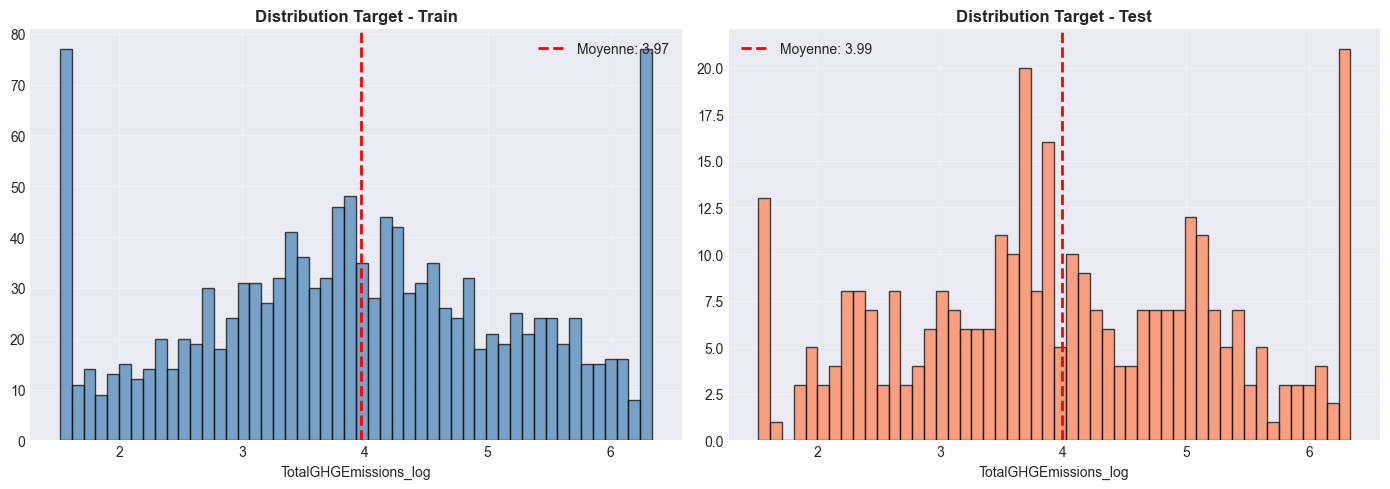

In [11]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_train.mean():.2f}')
axes[0].set_title('Distribution Target - Train', fontweight='bold')
axes[0].set_xlabel(TARGET)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_test, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {y_test.mean():.2f}')
axes[1].set_title('Distribution Target - Test', fontweight='bold')
axes[1].set_xlabel(TARGET)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Section 3 : Définition des Variables

In [12]:
# ============================================================================
# MODÈLE 1 : SANS ENERGY STAR
# ============================================================================

# Les données dans train_processed.csv sont déjà nettoyées (23 colonnes)

# Toutes colonnes SAUF target et ENERGYSTARScore
variables_m1 = [col for col in train_df.columns 
                if col != TARGET and col != 'ENERGYSTARScore' and col != 'TotalGHGEmissions']

# ============================================================================
# MODÈLE 2 : AVEC ENERGY STAR
# ============================================================================

# Toutes colonnes SAUF target
variables_m2 = [col for col in train_df.columns if col != TARGET and col != 'TotalGHGEmissions']

print(f"\n MODÈLE 1 : {len(variables_m1)} variables (sans ENERGY STAR)")
print(f" MODÈLE 2 : {len(variables_m2)} variables (avec ENERGY STAR)")

print(f"\n🔍 Variables MODÈLE 1 :")
print(variables_m1)
print(f"\n🔍 Variables MODÈLE 2 :")
print(variables_m2)


 MODÈLE 1 : 20 variables (sans ENERGY STAR)
 MODÈLE 2 : 21 variables (avec ENERGY STAR)

🔍 Variables MODÈLE 1 :
['BuildingType', 'PrimaryPropertyType', 'Address', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'HasElectricity', 'HasNaturalGas', 'HasSteam']

🔍 Variables MODÈLE 2 :
['BuildingType', 'PrimaryPropertyType', 'Address', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'HasElectricity', 'HasNaturalGas', 'HasSteam']


# Section 4 : Préparation des Datasets

In [13]:
# ============================================================================
# MODÈLE 1
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 1")
print("="*80)

X_train_m1 = train_df[variables_m1].copy()
X_test_m1 = test_df[variables_m1].copy()

# Gestion variables catégorielles
categorical_cols = X_train_m1.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    print(f"\n⚠ {len(categorical_cols)} variables catégorielles → OneHotEncoding")
    X_train_m1 = pd.get_dummies(X_train_m1, columns=categorical_cols, drop_first=True)
    X_test_m1 = pd.get_dummies(X_test_m1, columns=categorical_cols, drop_first=True)
    X_train_m1, X_test_m1 = X_train_m1.align(X_test_m1, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m1.shape[1]} features après encodage")

print(f"\n✓ X_train_m1 : {X_train_m1.shape}")
print(f"✓ X_test_m1  : {X_test_m1.shape}")

PRÉPARATION MODÈLE 1

⚠ 7 variables catégorielles → OneHotEncoding
   ✓ 1779 features après encodage

✓ X_train_m1 : (1332, 1779)
✓ X_test_m1  : (334, 1779)


In [14]:
# ============================================================================
# MODÈLE 2
# ============================================================================

print("="*80)
print("PRÉPARATION MODÈLE 2")
print("="*80)

X_train_m2 = train_df[variables_m2].copy()
X_test_m2 = test_df[variables_m2].copy()

# Imputation ENERGY STAR
if 'ENERGYSTARScore' in X_train_m2.columns:
    missing = X_train_m2['ENERGYSTARScore'].isnull().sum()
    if missing > 0:
        print(f"\n⚠ {missing} valeurs manquantes ENERGYSTARScore")
        median_val = X_train_m2['ENERGYSTARScore'].median()
        X_train_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        X_test_m2['ENERGYSTARScore'].fillna(median_val, inplace=True)
        print(f"   ✓ Imputation médiane = {median_val:.2f}")

# Gestion variables catégorielles
categorical_cols_m2 = X_train_m2.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols_m2) > 0:
    print(f"\n⚠ {len(categorical_cols_m2)} variables catégorielles → OneHotEncoding")
    X_train_m2 = pd.get_dummies(X_train_m2, columns=categorical_cols_m2, drop_first=True)
    X_test_m2 = pd.get_dummies(X_test_m2, columns=categorical_cols_m2, drop_first=True)
    X_train_m2, X_test_m2 = X_train_m2.align(X_test_m2, join='left', axis=1, fill_value=0)
    print(f"   ✓ {X_train_m2.shape[1]} features après encodage")

print(f"\n✓ X_train_m2 : {X_train_m2.shape}")
print(f"✓ X_test_m2  : {X_test_m2.shape}")

PRÉPARATION MODÈLE 2

⚠ 7 variables catégorielles → OneHotEncoding
   ✓ 1780 features après encodage

✓ X_train_m2 : (1332, 1780)
✓ X_test_m2  : (334, 1780)


# Section 5 : MODÈLE 1 - Baseline avec Pipelines

In [15]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 1
# ============================================================================

print("="*80)
print("MODÈLE 1 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m1 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}


print(f"\n✓ {len(pipelines_m1)} pipelines créés")

MODÈLE 1 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [16]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 1
# ============================================================================

results_df_m1, trained_pipelines_m1 = train_multiple_models(
    pipelines_m1,
    X_train_m1,
    y_train,
    X_test_m1,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 1")
display(results_df_m1[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 13.72s
   R² Test : 0.5196
   RMSE Test : 0.8924

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 2.18s
   R² Test : -0.0003
   RMSE Test : 1.2878

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 27.74s
   R² Test : 0.6047
   RMSE Test : 0.8096

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 15.91s
   R² Test : 0.6509
   RMSE Test : 0.7608

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 23.81s
   R² Test : 0.0337
   RMSE Test : 1.2657

✓ ENTRAÎNEMENT TERMINÉ

 RÉSULTATS BASELINE - MODÈLE 1


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
3,Gradient Boosting,0.6509,0.7608,0.5823,99.9095,96.4406,0.1594
2,Random Forest,0.6047,0.8096,0.5980,102.6289,112.2417,0.3549
0,Ridge,0.5196,0.8924,0.7019,117.1167,115.7154,0.4804
4,SVR,0.0337,1.2657,1.0468,139.8727,75.0681,0.8280
1,Lasso,-0.0003,1.2878,1.0602,161.4327,184.8346,0.0003


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\baseline_m1.png


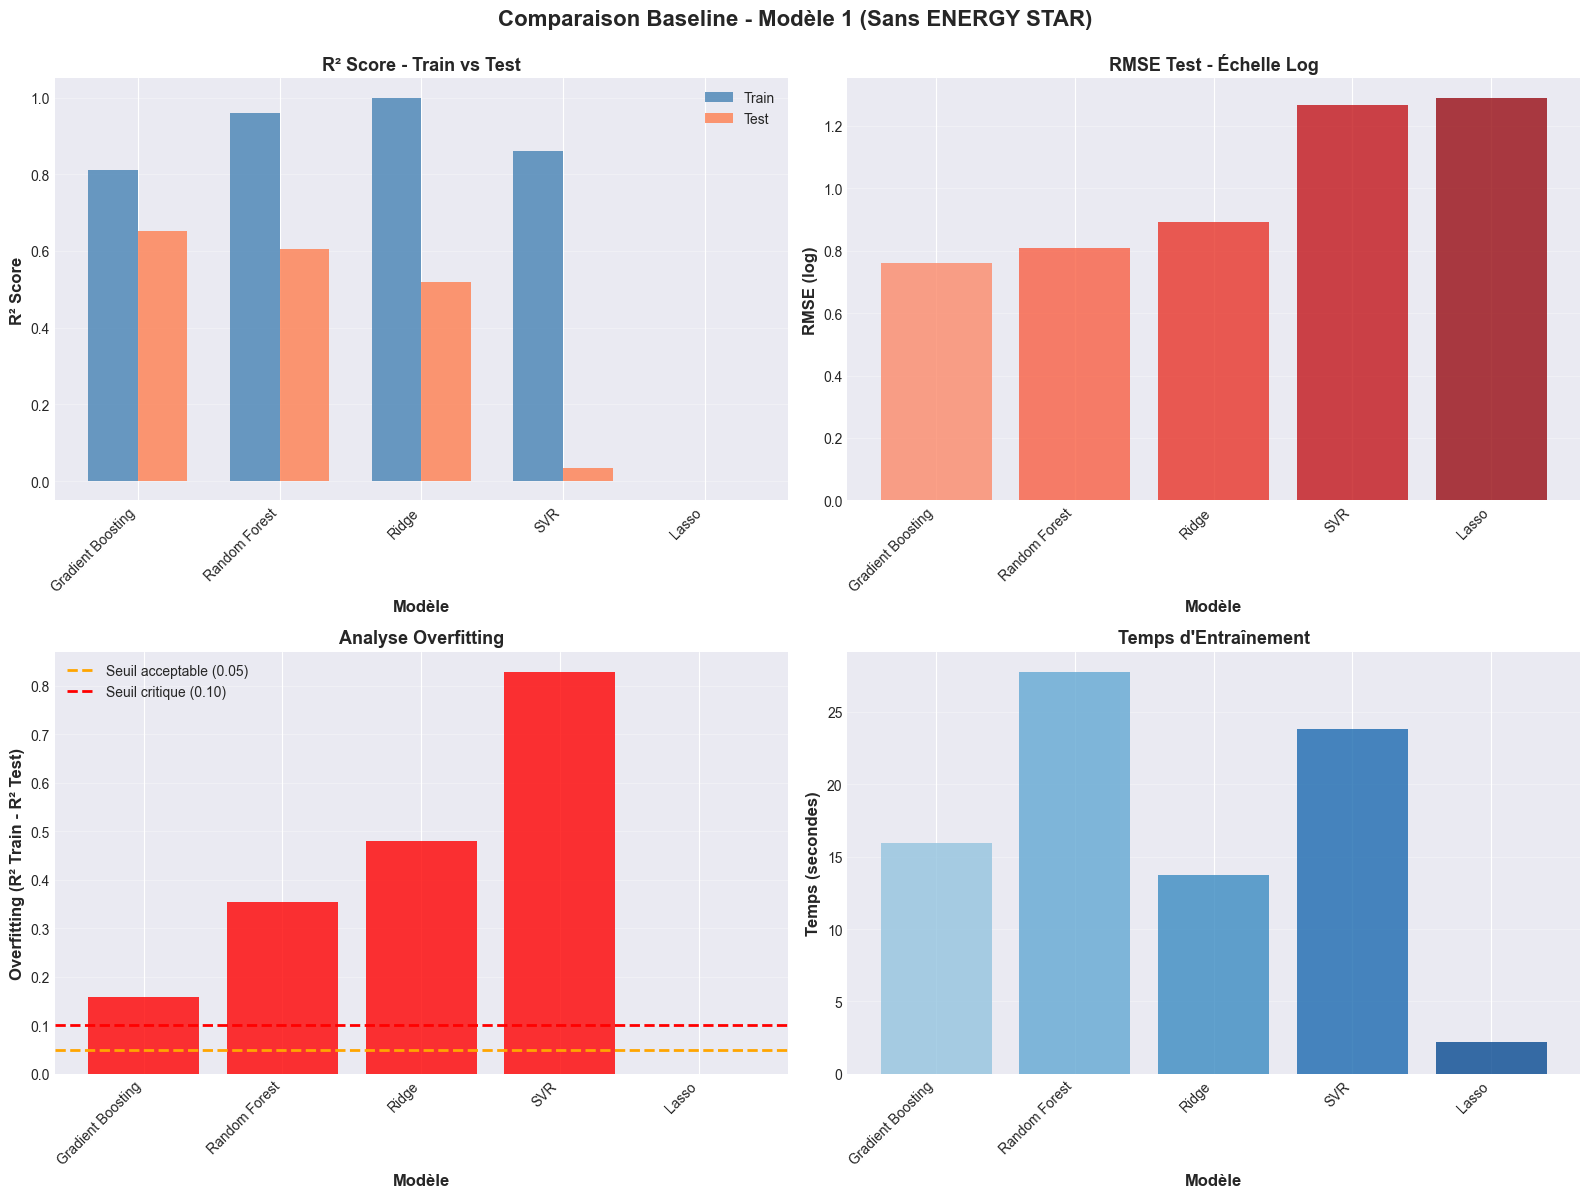

In [17]:
# Visualisation
plot_model_comparison(
    results_df_m1,
    title="Comparaison Baseline - Modèle 1 (Sans ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m1.png'
)

# Section 6 : MODÈLE 1 - Analyse

In [18]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 1
# ============================================================================

best_model_name_m1 = results_df_m1.iloc[0]['model']
best_pipeline_m1 = trained_pipelines_m1[best_model_name_m1]
best_metrics_m1 = results_df_m1.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 1 : {best_model_name_m1}")
print("="*80)

summary_m1 = calculate_metrics_summary(best_metrics_m1)
display(summary_m1)

MEILLEUR MODÈLE 1 : Gradient Boosting


,Métrique,Valeur,Interprétation
0,R² Score (Test),0.6509,Acceptable
1,RMSE (échelle originale),99.91 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),96.44%,À améliorer
3,Overfitting (R²),0.1594,Overfitting significatif


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\feature_importance_m1.png


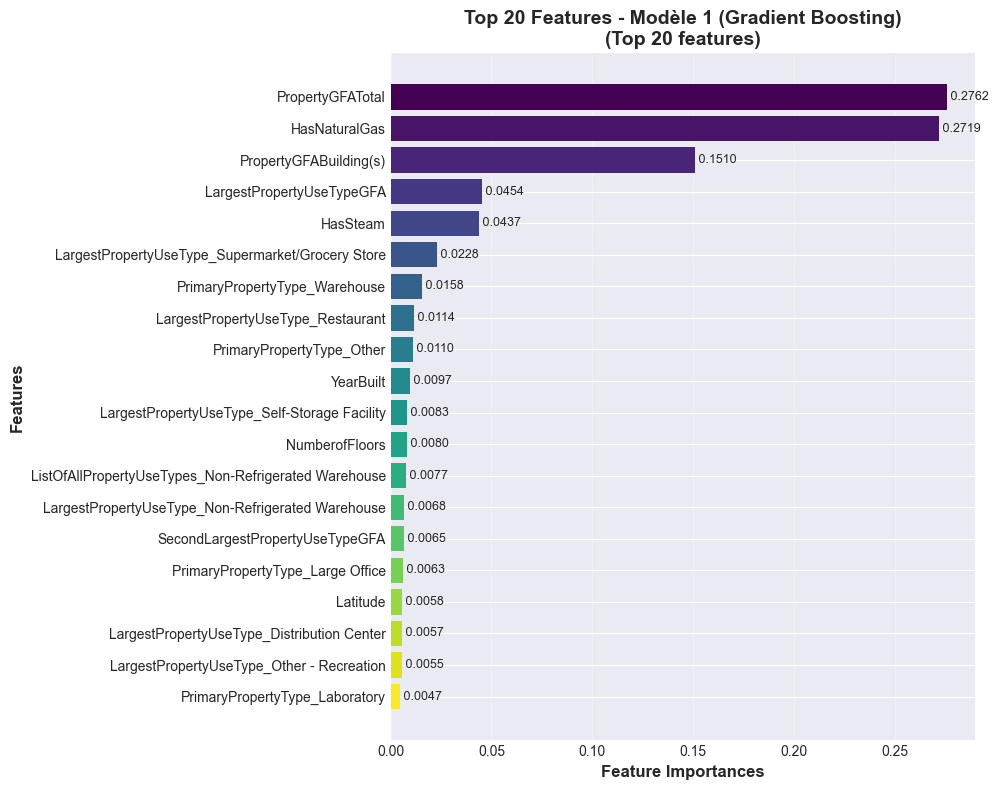


Top 10 Features :


,feature,importance
5,PropertyGFATotal,0.2762
11,HasNaturalGas,0.2719
7,PropertyGFABuilding(s),0.1510
8,LargestPropertyUseTypeGFA,0.0454
12,HasSteam,0.0437
1732,LargestPropertyUseType_Supermarket/Grocery Store,0.0228
35,PrimaryPropertyType_Warehouse,0.0158
1726,LargestPropertyUseType_Restaurant,0.0114
25,PrimaryPropertyType_Other,0.0110
2,YearBuilt,0.0097


In [19]:
# Feature Importance
if hasattr(best_pipeline_m1.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m1.named_steps['model'], 'coef_'):
    
    importance_df_m1 = plot_feature_importance(
        best_pipeline_m1.named_steps['model'],
        X_train_m1.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 1 ({best_model_name_m1})",
        save_path=FIGURES_DIR / 'feature_importance_m1.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m1.head(10))
else:
    print("⚠ Feature importance non disponible pour ce modèle")

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\predictions_m1.png


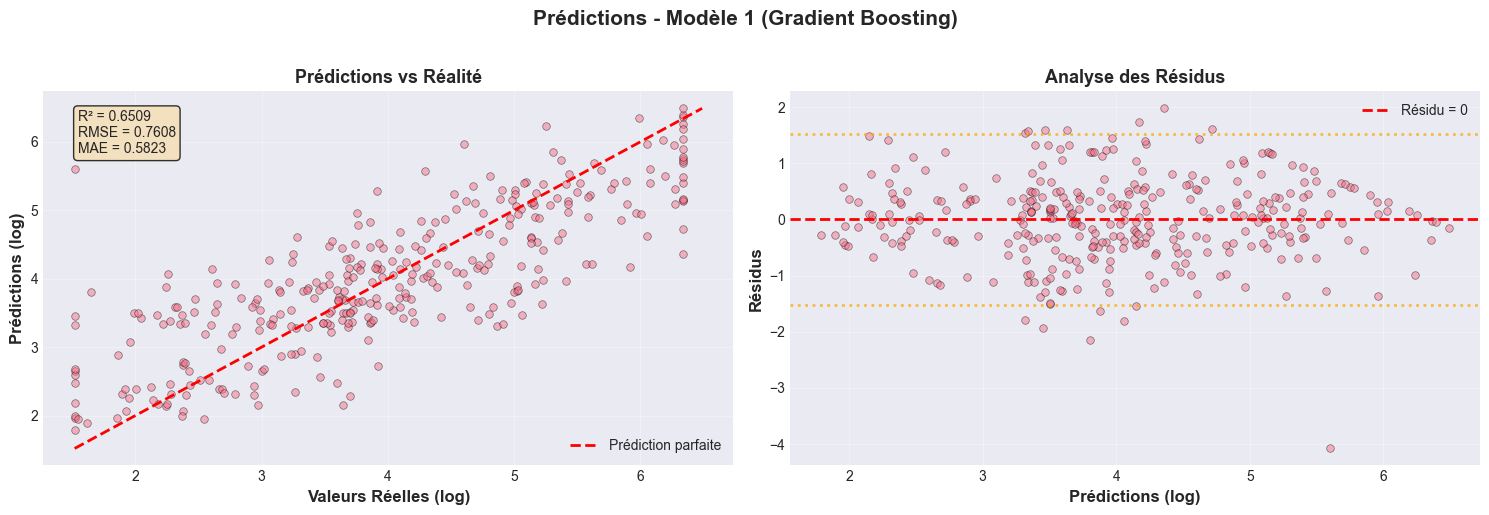

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\residuals_m1.png


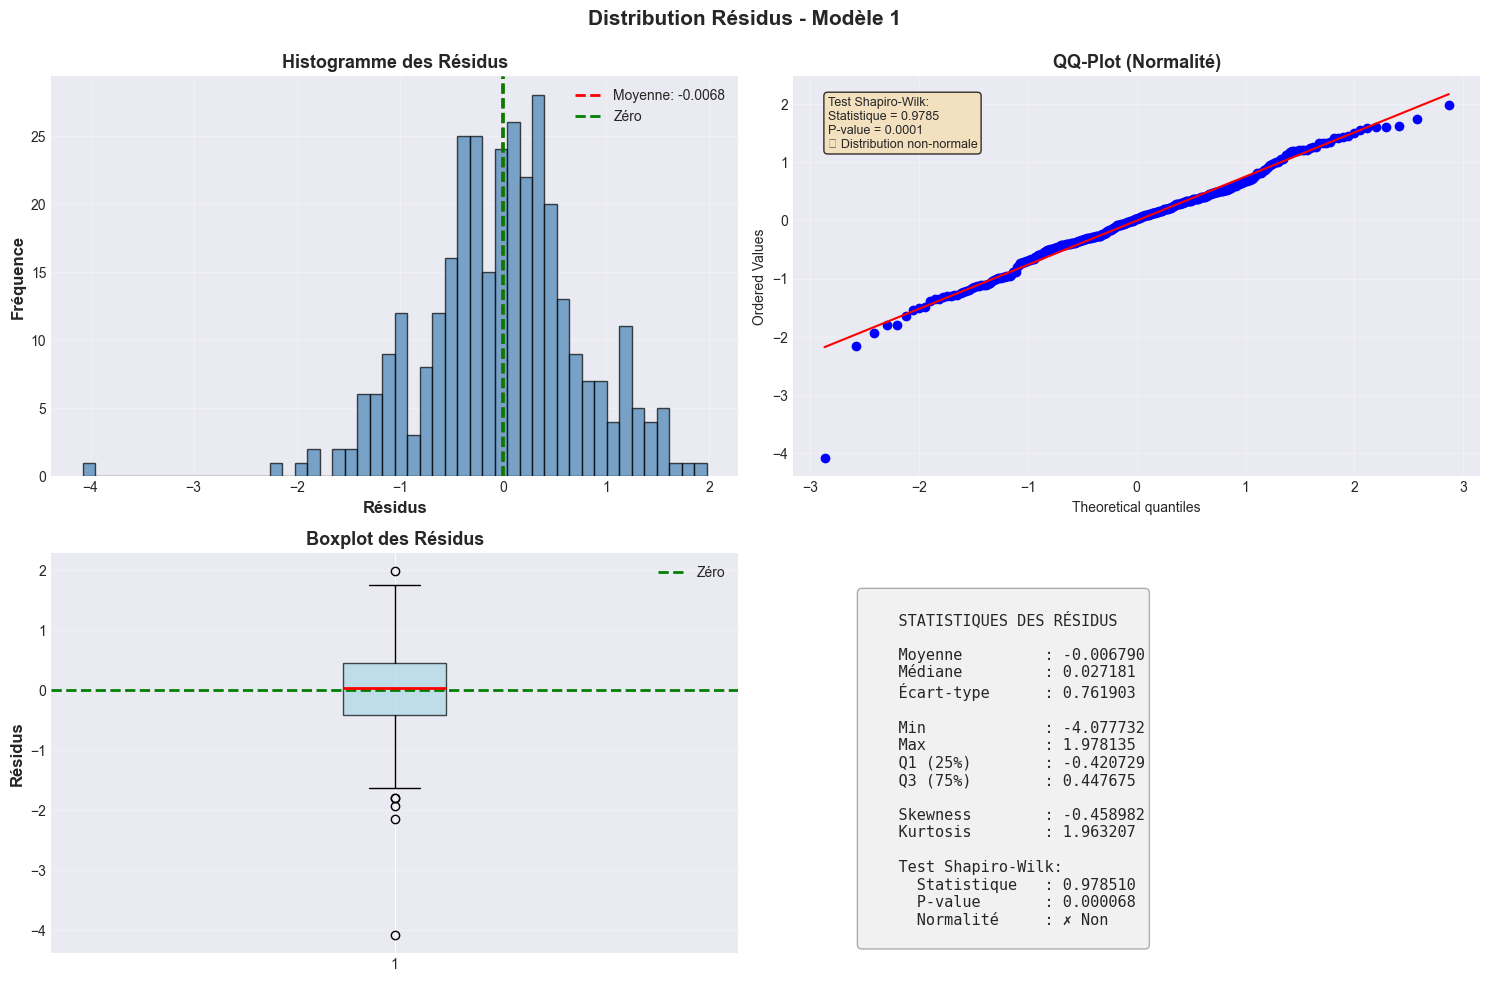

In [20]:
# Analyse Résidus
y_pred_m1 = best_pipeline_m1.predict(X_test_m1)

plot_predictions(
    y_test, y_pred_m1,
    title=f"Prédictions - Modèle 1 ({best_model_name_m1})",
    save_path=FIGURES_DIR / 'predictions_m1.png'
)

residuals_m1 = y_test - y_pred_m1
plot_residuals_distribution(
    residuals_m1,
    title="Distribution Résidus - Modèle 1",
    save_path=FIGURES_DIR / 'residuals_m1.png'
)

# Section 7 : MODÈLE 2 - Baseline avec Pipelines

In [21]:
# ============================================================================
# DÉFINITION PIPELINES - MODÈLE 2
# ============================================================================

print("="*80)
print("MODÈLE 2 - BASELINE AVEC PIPELINES")
print("="*80)

pipelines_m2 = {
    'Ridge': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Ridge(random_state=RANDOM_STATE))
    ]),
    
    'Lasso': Pipeline([
        ('scaler', StandardScaler()),
        ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
    ]),
    
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]),
    
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE
        ))
    ]),
    
    'SVR': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf'))
    ])
}



print(f"\n✓ {len(pipelines_m2)} pipelines créés")

MODÈLE 2 - BASELINE AVEC PIPELINES

✓ 5 pipelines créés


In [22]:
# ============================================================================
# ENTRAÎNEMENT - MODÈLE 2
# ============================================================================

results_df_m2, trained_pipelines_m2 = train_multiple_models(
    pipelines_m2,
    X_train_m2,
    y_train,
    X_test_m2,
    y_test,
    cv=5,
    verbose=True
)

print("\n RÉSULTATS BASELINE - MODÈLE 2")
display(results_df_m2[['model', 'test_r2', 'test_rmse_log', 'test_mae_log', 
                       'test_rmse_original', 'test_mape', 'overfitting_r2']].round(4))

ENTRAÎNEMENT MULTIPLE MODÈLES

Nombre de modèles : 5
Cross-validation : 5-fold

Traitement : Ridge
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 2.77s
   R² Test : 0.5187
   RMSE Test : 0.8933

Traitement : Lasso
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 1.77s
   R² Test : -0.0003
   RMSE Test : 1.2878

Traitement : Random Forest
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 24.15s
   R² Test : 0.6284
   RMSE Test : 0.7849

Traitement : Gradient Boosting
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 19.47s
   R² Test : 0.6833
   RMSE Test : 0.7246

Traitement : SVR
   → Cross-validation...
   → Entraînement...
   → Évaluation...
   ✓ Terminé en 31.47s
   R² Test : 0.0414
   RMSE Test : 1.2607

✓ ENTRAÎNEMENT TERMINÉ

 RÉSULTATS BASELINE - MODÈLE 2


,model,test_r2,test_rmse_log,test_mae_log,test_rmse_original,test_mape,overfitting_r2
3,Gradient Boosting,0.6833,0.7246,0.5506,96.5127,87.9957,0.1504
2,Random Forest,0.6284,0.7849,0.5826,101.0773,112.6237,0.3334
0,Ridge,0.5187,0.8933,0.7031,116.9504,115.6902,0.4813
4,SVR,0.0414,1.2607,1.0446,138.9653,74.5182,0.8233
1,Lasso,-0.0003,1.2878,1.0602,161.4327,184.8346,0.0003


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\baseline_m2.png


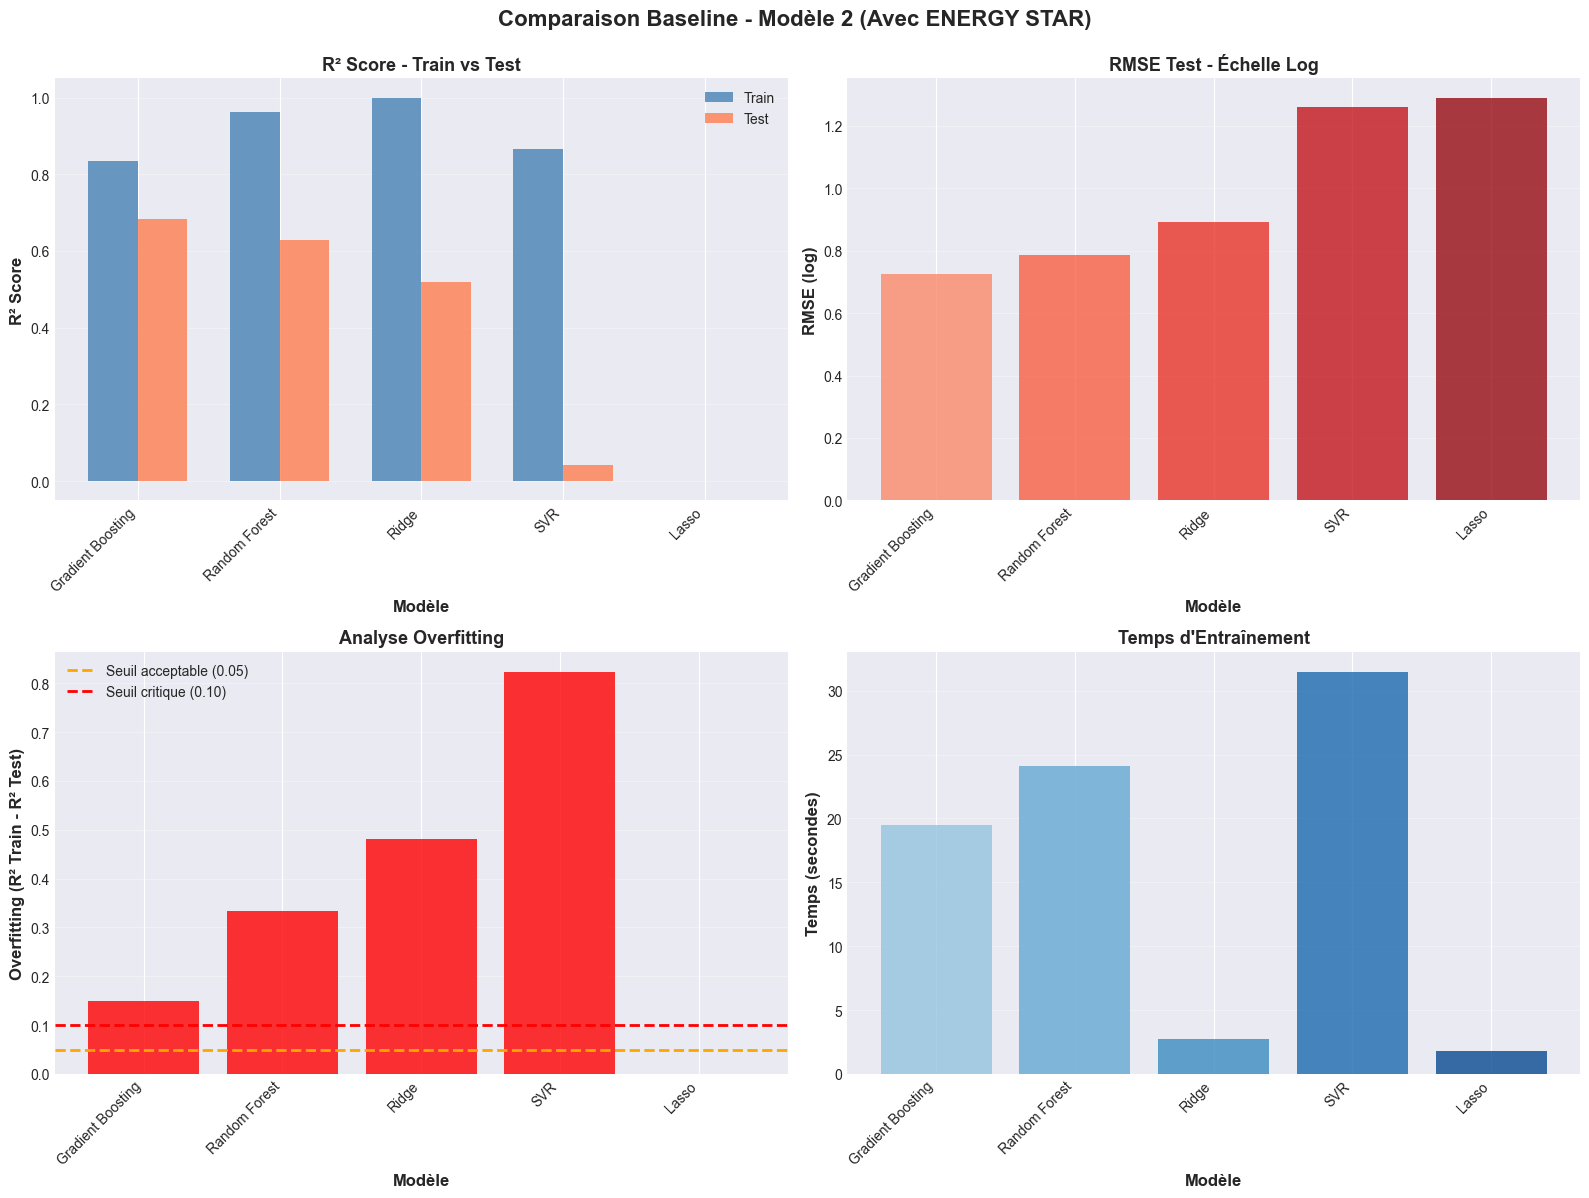

In [23]:
# Visualisation
plot_model_comparison(
    results_df_m2,
    title="Comparaison Baseline - Modèle 2 (Avec ENERGY STAR)",
    save_path=FIGURES_DIR / 'baseline_m2.png'
)

# Section 8 : MODÈLE 2 - Analyse

In [24]:
# ============================================================================
# MEILLEUR MODÈLE - MODÈLE 2
# ============================================================================

best_model_name_m2 = results_df_m2.iloc[0]['model']
best_pipeline_m2 = trained_pipelines_m2[best_model_name_m2]
best_metrics_m2 = results_df_m2.iloc[0].to_dict()

print("="*80)
print(f"MEILLEUR MODÈLE 2 : {best_model_name_m2}")
print("="*80)

summary_m2 = calculate_metrics_summary(best_metrics_m2)
display(summary_m2)

MEILLEUR MODÈLE 2 : Gradient Boosting


,Métrique,Valeur,Interprétation
0,R² Score (Test),0.6833,Acceptable
1,RMSE (échelle originale),96.51 tonnes CO₂,Erreur moyenne quadratique
2,MAPE (%),88.00%,À améliorer
3,Overfitting (R²),0.1504,Overfitting significatif


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\feature_importance_m2.png


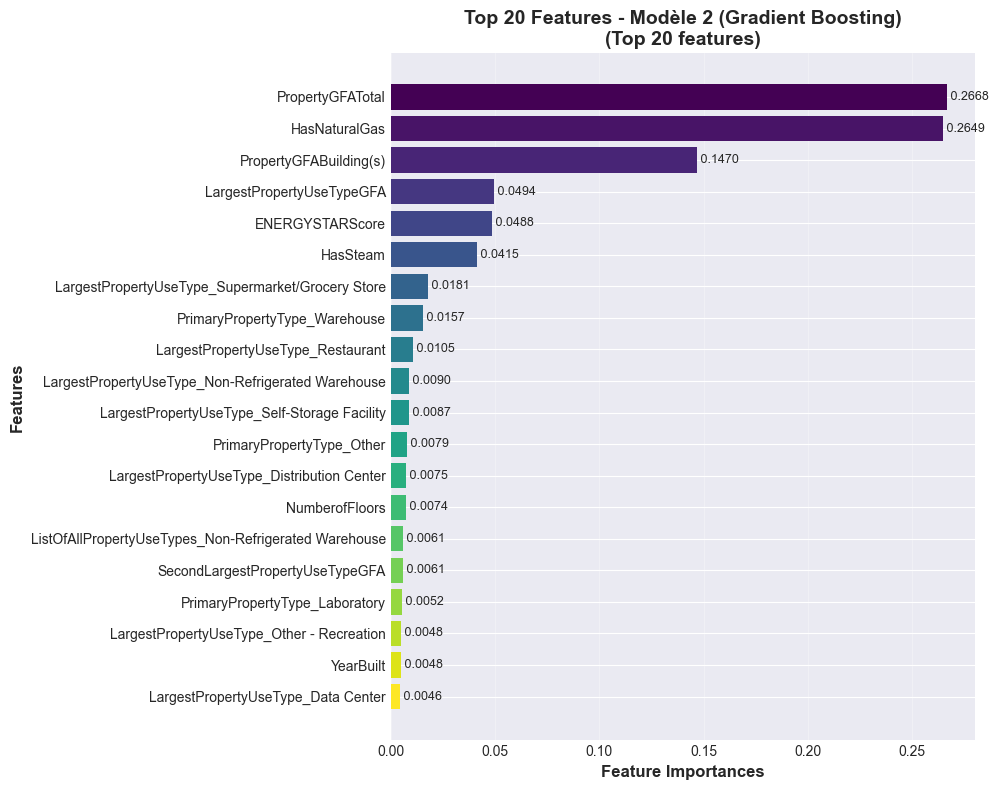


Top 10 Features :


,feature,importance
5,PropertyGFATotal,0.2668
12,HasNaturalGas,0.2649
7,PropertyGFABuilding(s),0.1470
8,LargestPropertyUseTypeGFA,0.0494
10,ENERGYSTARScore,0.0488
13,HasSteam,0.0415
1733,LargestPropertyUseType_Supermarket/Grocery Store,0.0181
36,PrimaryPropertyType_Warehouse,0.0157
1727,LargestPropertyUseType_Restaurant,0.0105
1705,LargestPropertyUseType_Non-Refrigerated Warehouse,0.0090



 ENERGYSTARScore : Rang 11 | Importance 0.0488


In [ ]:
# Feature Importance + Position ENERGY STAR
if hasattr(best_pipeline_m2.named_steps['model'], 'feature_importances_') or \
   hasattr(best_pipeline_m2.named_steps['model'], 'coef_'):
    
    importance_df_m2 = plot_feature_importance(
        best_pipeline_m2.named_steps['model'],
        X_train_m2.columns,
        top_n=20,
        title=f"Top 20 Features - Modèle 2 ({best_model_name_m2})",
        save_path=FIGURES_DIR / 'feature_importance_m2.png'
    )
    
    print("\nTop 10 Features :")
    display(importance_df_m2.head(10))
    
    # Position ENERGY STARs
    if 'ENERGYSTARScore' in importance_df_m2['feature'].values:
        energy_rank = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore'].index[0] + 1
        energy_importance = importance_df_m2[importance_df_m2['feature'] == 'ENERGYSTARScore']['importance'].values[0]
        print(f"\n ENERGYSTARScore : Rang {energy_rank} | Importance {energy_importance:.4f}")
else:
    print("⚠ Feature importance non disponible")

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\predictions_m2.png


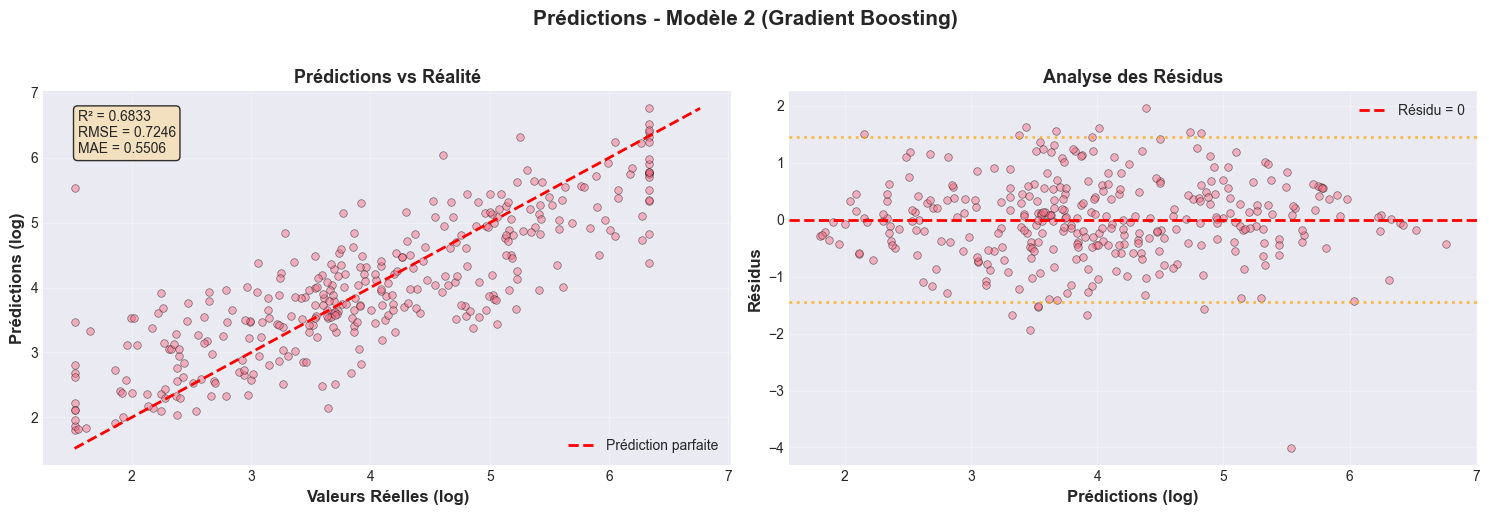

✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\residuals_m2.png


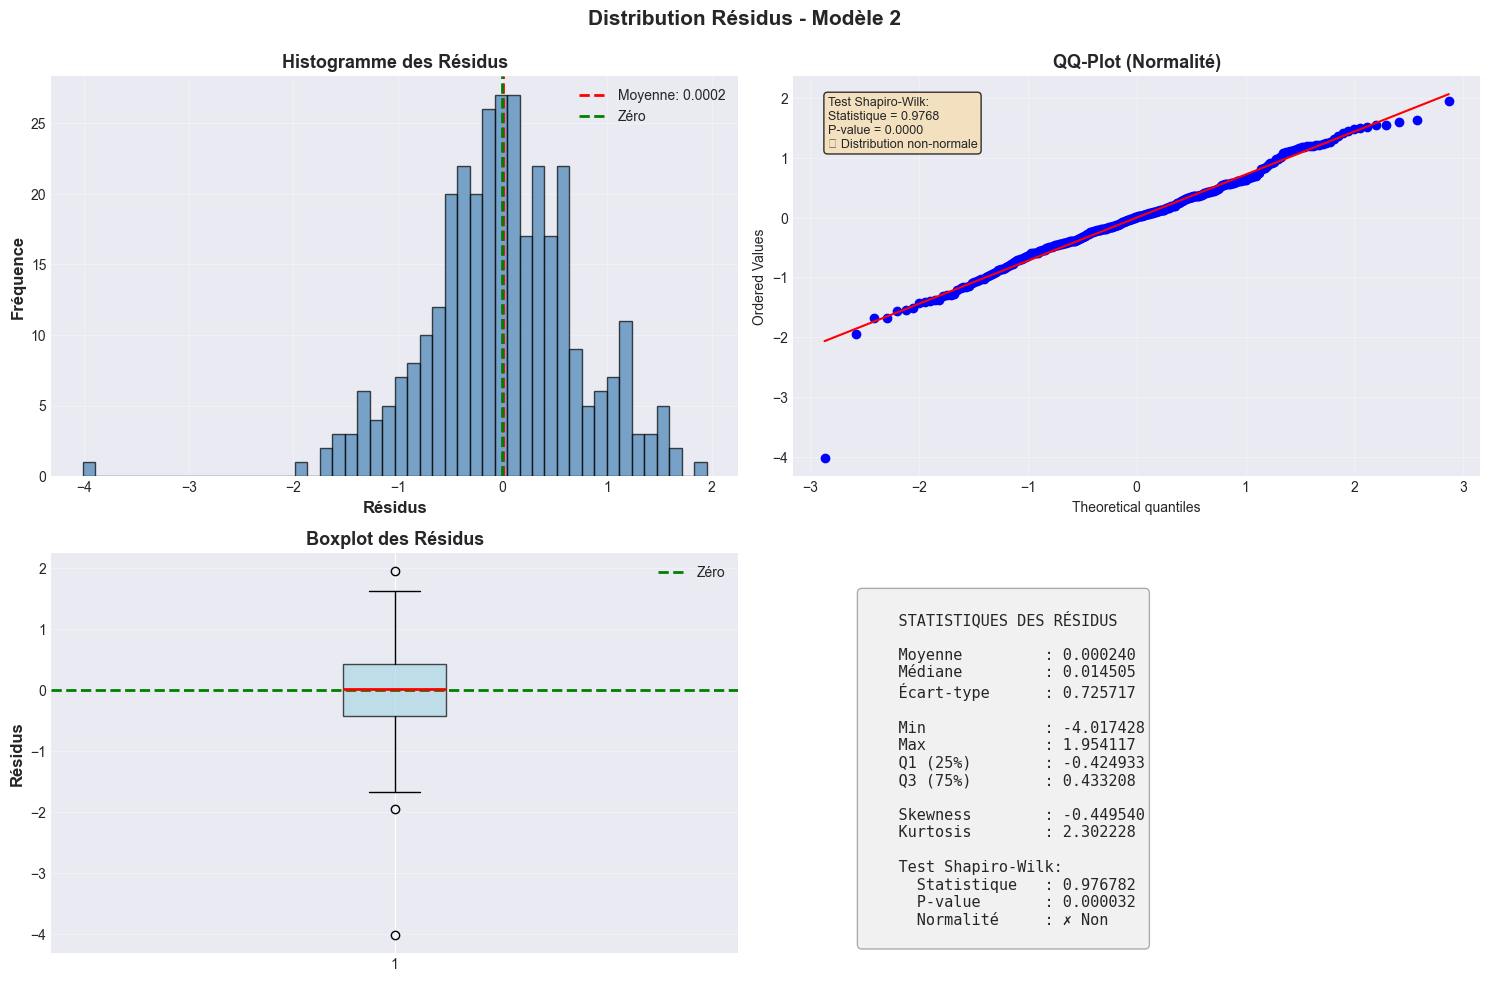

In [26]:
# Analyse Résidus
y_pred_m2 = best_pipeline_m2.predict(X_test_m2)

plot_predictions(
    y_test, y_pred_m2,
    title=f"Prédictions - Modèle 2 ({best_model_name_m2})",
    save_path=FIGURES_DIR / 'predictions_m2.png'
)

residuals_m2 = y_test - y_pred_m2
plot_residuals_distribution(
    residuals_m2,
    title="Distribution Résidus - Modèle 2",
    save_path=FIGURES_DIR / 'residuals_m2.png'
)

# Section 8.5 : Comparaison Rigoureuse (Même Algorithme)

---

##  MÉTHODOLOGIE CORRECTE

Pour comparer scientifiquement l'apport d'**ENERGY STAR**, on doit comparer **le même algorithme** dans les 2 scénarios :

1. **Identifier le meilleur algorithme global** (tous modèles M1 et M2 confondus)
2. **Comparer cet algorithme** avec/sans ENERGY STAR
3. **Isoler l'effet pur** de la variable ENERGY STAR

 **Approche incorrecte** : Comparer le meilleur de M1 (ex: Gradient Boosting) avec le meilleur de M2 (ex: Random Forest)

 **Approche correcte** : Identifier d'abord le meilleur algorithme global, puis comparer cet algorithme dans les 2 scénarios

---

IDENTIFICATION MEILLEUR ALGORITHME GLOBAL

🏆 TOP 5 MEILLEURS MODÈLES (TOUS SCÉNARIOS CONFONDUS)


,model,scenario,test_r2,test_rmse_log,test_mae_log
3,Gradient Boosting,Modèle 2 (Avec ENERGY STAR),0.6833,0.7246,0.5506
3,Gradient Boosting,Modèle 1 (Sans ENERGY STAR),0.6509,0.7608,0.5823
2,Random Forest,Modèle 2 (Avec ENERGY STAR),0.6284,0.7849,0.5826
2,Random Forest,Modèle 1 (Sans ENERGY STAR),0.6047,0.8096,0.5980
0,Ridge,Modèle 1 (Sans ENERGY STAR),0.5196,0.8924,0.7019



✨ Meilleur algorithme global : Gradient Boosting

COMPARAISON GRADIENT BOOSTING : AVEC vs SANS ENERGY STAR

 TABLEAU COMPARATIF


,Métrique,Modèle 1 (Sans ENERGY STAR),Modèle 2 (Avec ENERGY STAR),Gain Absolu,Gain %
0,R²,0.6509,0.6833,0.0324,4.9780
1,RMSE,0.7608,0.7246,-0.0362,-4.7533
2,MAE,0.5823,0.5506,-0.0317,-5.4410



 INTERPRÉTATION DES RÉSULTATS

 Apport d' ENERGY STAR pour Gradient Boosting :
   • Gain R²   : +0.0324 (+4.98%)
   • Gain RMSE : +0.0362 (+4.75%)
   • Gain MAE  : +0.0317 (+5.44%)

 CONCLUSION : ENERGY STAR améliore significativement la prédiction
   Le modèle explique 3.24% de variance supplémentaire

 Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\comparison_rigorous.png


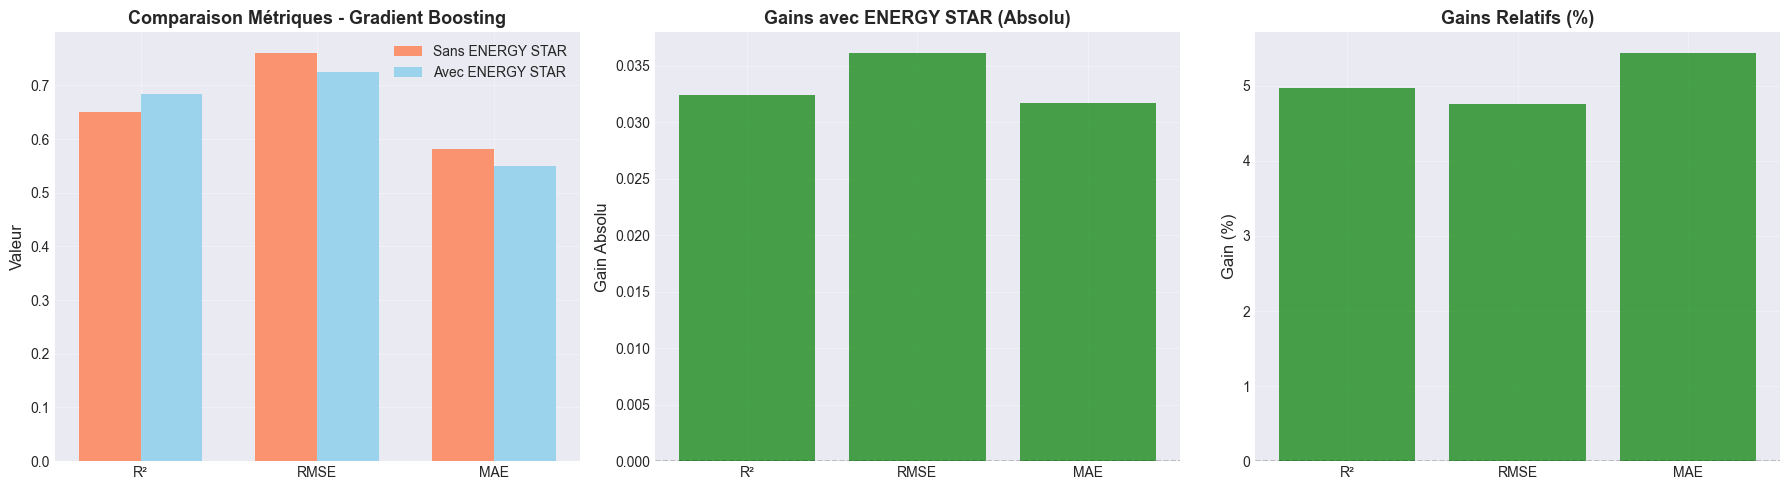

 Comparaison sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\comparison_rigorous.csv

 COMPARAISON RIGOUREUSE TERMINÉE


In [27]:
print("="*80)
print("IDENTIFICATION MEILLEUR ALGORITHME GLOBAL")
print("="*80)

# ============================================================================
# COMBINER TOUS LES RÉSULTATS
# ============================================================================

all_results = pd.concat([
    results_df_m1.assign(scenario='Modèle 1 (Sans ENERGY STAR)'),
    results_df_m2.assign(scenario='Modèle 2 (Avec ENERGY STAR)')
])

# Trier par R² test (meilleur = plus élevé)
all_results_sorted = all_results.sort_values('test_r2', ascending=False)

print("\n🏆 TOP 5 MEILLEURS MODÈLES (TOUS SCÉNARIOS CONFONDUS)")
print("="*80)
display(all_results_sorted[['model', 'scenario', 'test_r2', 'test_rmse_log', 'test_mae_log']].head())

# Identifier meilleur algorithme
best_algorithm = all_results_sorted.iloc[0]['model']
print(f"\n✨ Meilleur algorithme global : {best_algorithm}")

# ============================================================================
# COMPARAISON RIGOUREUSE : MÊME ALGORITHME AVEC/SANS ENERGY STAR
# ============================================================================

print("\n" + "="*80)
print(f"COMPARAISON {best_algorithm.upper()} : AVEC vs SANS ENERGY STAR")
print("="*80)

# Extraire les résultats pour cet algorithme dans les 2 scénarios
best_m1_algo = results_df_m1[results_df_m1['model'] == best_algorithm].iloc[0]
best_m2_algo = results_df_m2[results_df_m2['model'] == best_algorithm].iloc[0]

# Créer DataFrame de comparaison
comparison_df = pd.DataFrame({
    'Métrique': ['R²', 'RMSE', 'MAE'],
    'Modèle 1 (Sans ENERGY STAR)': [
        best_m1_algo['test_r2'],
        best_m1_algo['test_rmse_log'],
        best_m1_algo['test_mae_log']
    ],
    'Modèle 2 (Avec ENERGY STAR)': [
        best_m2_algo['test_r2'],
        best_m2_algo['test_rmse_log'],
        best_m2_algo['test_mae_log']
    ]
})

# Calculer gains
comparison_df['Gain Absolu'] = comparison_df['Modèle 2 (Avec ENERGY STAR)'] - comparison_df['Modèle 1 (Sans ENERGY STAR)']
comparison_df['Gain %'] = (comparison_df['Gain Absolu'] / comparison_df['Modèle 1 (Sans ENERGY STAR)'].abs()) * 100

print("\n TABLEAU COMPARATIF")
display(comparison_df.round(4))

# ============================================================================
# CALCUL DES GAINS
# ============================================================================

gain_r2 = best_m2_algo['test_r2'] - best_m1_algo['test_r2']
gain_rmse = best_m1_algo['test_rmse_log'] - best_m2_algo['test_rmse_log']  # Positif = amélioration
gain_mae = best_m1_algo['test_mae_log'] - best_m2_algo['test_mae_log']

print("\n" + "="*80)
print(" INTERPRÉTATION DES RÉSULTATS")
print("="*80)

print(f"\n Apport d' ENERGY STAR pour {best_algorithm} :")
print(f"   • Gain R²   : {gain_r2:+.4f} ({(gain_r2/best_m1_algo['test_r2']*100):+.2f}%)")
print(f"   • Gain RMSE : {gain_rmse:+.4f} ({(gain_rmse/best_m1_algo['test_rmse_log']*100):+.2f}%)")
print(f"   • Gain MAE  : {gain_mae:+.4f} ({(gain_mae/best_m1_algo['test_mae_log']*100):+.2f}%)")

if gain_r2 > 0:
    print(f"\n CONCLUSION : ENERGY STAR améliore significativement la prédiction")
    print(f"   Le modèle explique {gain_r2*100:.2f}% de variance supplémentaire")
else:
    print(f"\n CONCLUSION : ENERGY STAR n'apporte pas d'amélioration notable")

# ============================================================================
# VISUALISATION GRAPHIQUE
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Graphique 1 : Comparaison métriques
metrics = ['R²', 'RMSE', 'MAE']
m1_values = [best_m1_algo['test_r2'], best_m1_algo['test_rmse_log'], best_m1_algo['test_mae_log']]
m2_values = [best_m2_algo['test_r2'], best_m2_algo['test_rmse_log'], best_m2_algo['test_mae_log']]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, m1_values, width, label='Sans ENERGY STAR', alpha=0.8, color='coral')
axes[0].bar(x + width/2, m2_values, width, label='Avec ENERGY STAR', alpha=0.8, color='skyblue')
axes[0].set_ylabel('Valeur', fontsize=12)
axes[0].set_title(f'Comparaison Métriques - {best_algorithm}', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Gains absolus
gains = [gain_r2, gain_rmse, gain_mae]
colors = ['green' if g > 0 else 'red' for g in gains]
axes[1].bar(metrics, gains, color=colors, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_ylabel('Gain Absolu', fontsize=12)
axes[1].set_title('Gains avec ENERGY STAR (Absolu)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Graphique 3 : Gains en %
gains_pct = [
    (gain_r2 / best_m1_algo['test_r2']) * 100,
    (gain_rmse / best_m1_algo['test_rmse_log']) * 100,
    (gain_mae / best_m1_algo['test_mae_log']) * 100
]
colors = ['green' if g > 0 else 'red' for g in gains_pct]
axes[2].bar(metrics, gains_pct, color=colors, alpha=0.7)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_ylabel('Gain (%)', fontsize=12)
axes[2].set_title('Gains Relatifs (%)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'comparison_rigorous.png', dpi=300, bbox_inches='tight')
print(f"\n Figure sauvegardée : {FIGURES_DIR / 'comparison_rigorous.png'}")
plt.show()

# ============================================================================
# SAUVEGARDE RÉSULTATS
# ============================================================================

comparison_df.to_csv(RESULTS_DIR / 'comparison_rigorous.csv', index=False)
print(f" Comparaison sauvegardée : {RESULTS_DIR / 'comparison_rigorous.csv'}")

print("\n" + "="*80)
print(" COMPARAISON RIGOUREUSE TERMINÉE")
print("="*80)

# Section 9 : Comparaison MODÈLE 1 vs MODÈLE 2

In [28]:
# ============================================================================
# COMPARAISON DÉTAILLÉE
# ============================================================================

print("="*80)
print("COMPARAISON MODÈLE 1 vs MODÈLE 2")
print("="*80)

comparison = compare_model_performance(
    best_metrics_m1,
    best_metrics_m2,
    "Modèle 1 (Sans ENERGY STAR)",
    "Modèle 2 (Avec ENERGY STAR)"
)

display(comparison)

COMPARAISON MODÈLE 1 vs MODÈLE 2


,Métrique,Modèle 1 (Sans ENERGY STAR),Modèle 2 (Avec ENERGY STAR),Différence,Amélioration (%),Meilleur
0,R² Test,0.6509,0.6833,+0.0324,+4.98%,Modèle 2 (Avec ENERGY STAR)
1,RMSE Test (log),0.7608,0.7246,-0.0362,+4.75%,Modèle 2 (Avec ENERGY STAR)
2,MAE Test (log),0.5823,0.5506,-0.0317,+5.44%,Modèle 2 (Avec ENERGY STAR)
3,RMSE Test (original),99.9095,96.5127,-3.3969,+3.40%,Modèle 2 (Avec ENERGY STAR)
4,MAPE Test (%),96.4406,87.9957,-8.4449,+8.76%,Modèle 2 (Avec ENERGY STAR)
5,Overfitting R²,0.1594,0.1504,-0.0090,+5.67%,Modèle 2 (Avec ENERGY STAR)


✓ Figure sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\figures\comparison_m1_m2.png


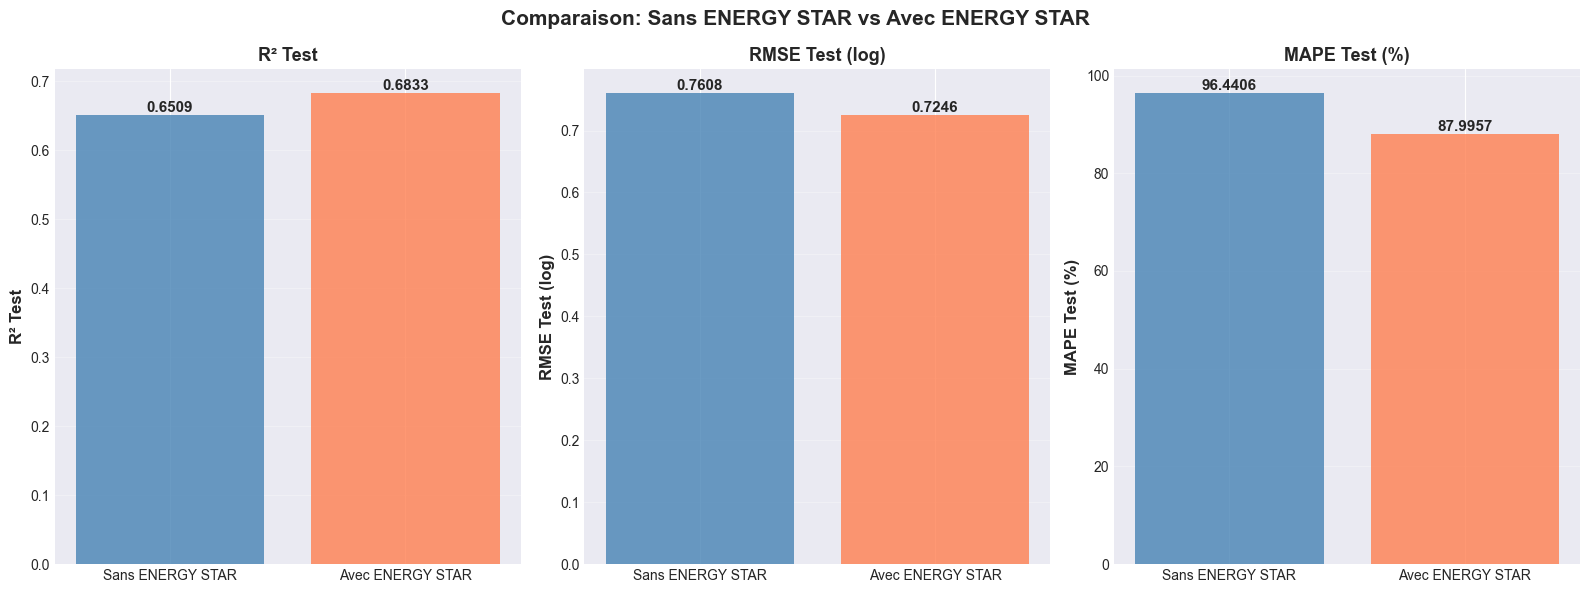

In [29]:
# Visualisation comparative
plot_comparison_two_models(
    results_df_m1,
    results_df_m2,
    "Sans ENERGY STAR",
    "Avec ENERGY STAR",
    save_path=FIGURES_DIR / 'comparison_m1_m2.png'
)

# Section 10 : Analyse Apport ENERGY STAR

In [30]:
# ============================================================================
# ANALYSE APPORT ENERGY STAR
# ============================================================================

print("="*80)
print("ANALYSE APPORT ENERGY STAR SCORE")
print("="*80)

gain_r2 = best_metrics_m2['test_r2'] - best_metrics_m1['test_r2']
gain_rmse = best_metrics_m1['test_rmse_log'] - best_metrics_m2['test_rmse_log']
gain_mape = best_metrics_m1['test_mape'] - best_metrics_m2['test_mape']

print(f"\n GAINS DE PERFORMANCE")
print(f"\nR² Score :")
print(f"  Modèle 1 : {best_metrics_m1['test_r2']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_r2']:.4f}")
print(f"  Gain     : {gain_r2:+.4f} ({gain_r2/best_metrics_m1['test_r2']*100:+.1f}%)")

print(f"\nRMSE (log) :")
print(f"  Modèle 1 : {best_metrics_m1['test_rmse_log']:.4f}")
print(f"  Modèle 2 : {best_metrics_m2['test_rmse_log']:.4f}")
print(f"  Gain     : {gain_rmse:+.4f} ({gain_rmse/best_metrics_m1['test_rmse_log']*100:+.1f}%)")

print(f"\nMAPE :")
print(f"  Modèle 1 : {best_metrics_m1['test_mape']:.2f}%")
print(f"  Modèle 2 : {best_metrics_m2['test_mape']:.2f}%")
print(f"  Gain     : {gain_mape:+.2f}%")

ANALYSE APPORT ENERGY STAR SCORE

 GAINS DE PERFORMANCE

R² Score :
  Modèle 1 : 0.6509
  Modèle 2 : 0.6833
  Gain     : +0.0324 (+5.0%)

RMSE (log) :
  Modèle 1 : 0.7608
  Modèle 2 : 0.7246
  Gain     : +0.0362 (+4.8%)

MAPE :
  Modèle 1 : 96.44%
  Modèle 2 : 88.00%
  Gain     : +8.44%



 Corrélation ENERGYSTARScore - Target : -0.1072


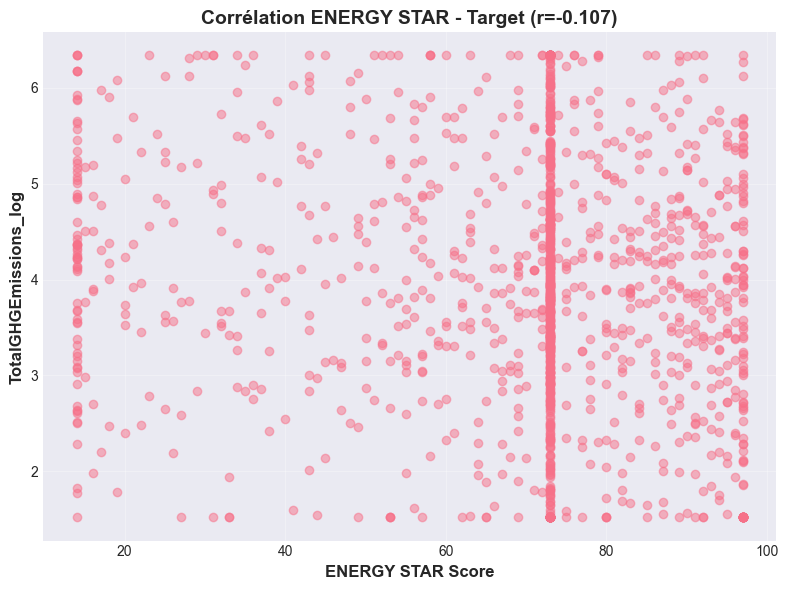

In [31]:
# Corrélation ENERGY STAR avec Target
if 'ENERGYSTARScore' in train_df.columns:
    corr = train_df[['ENERGYSTARScore', TARGET]].corr().iloc[0, 1]
    print(f"\n Corrélation ENERGYSTARScore - Target : {corr:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.scatter(train_df['ENERGYSTARScore'], train_df[TARGET], alpha=0.5)
    plt.xlabel('ENERGY STAR Score', fontsize=12, fontweight='bold')
    plt.ylabel(TARGET, fontsize=12, fontweight='bold')
    plt.title(f'Corrélation ENERGY STAR - Target (r={corr:.3f})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'energy_star_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Section 11 : Recommandations Stratégiques

In [32]:
print("="*80)
print("RECOMMANDATIONS STRATÉGIQUES")
print("="*80)

print("\n QUAND UTILISER QUEL MODÈLE ?")

print("\n MODÈLE 1 (Sans ENERGY STAR) :")
print("  • Prédiction sur nouveaux bâtiments (permis de construction)")
print("  • ENERGY STAR Score non disponible")
print("  • Approche prédictive pure")
print(f"  • Performance : R² = {best_metrics_m1['test_r2']:.3f}")

print("\n MODÈLE 2 (Avec ENERGY STAR) :")
print("  • Bâtiments existants avec certification ENERGY STAR")
print("  • Maximisation de la performance prédictive")
print("  • Évaluation de l'efficacité énergétique")
print(f"  • Performance : R² = {best_metrics_m2['test_r2']:.3f}")

print(f"\n GAIN ENERGY STAR : {gain_r2/best_metrics_m1['test_r2']*100:+.1f}% de variance expliquée")

if gain_r2 > 0.1:
    print("\n CONCLUSION : ENERGY STAR apporte un gain SIGNIFICATIF")
elif gain_r2 > 0.05:
    print("\n CONCLUSION : ENERGY STAR apporte un gain MODÉRÉ")
else:
    print("\n CONCLUSION : ENERGY STAR apporte un gain FAIBLE")

RECOMMANDATIONS STRATÉGIQUES

 QUAND UTILISER QUEL MODÈLE ?

 MODÈLE 1 (Sans ENERGY STAR) :
  • Prédiction sur nouveaux bâtiments (permis de construction)
  • ENERGY STAR Score non disponible
  • Approche prédictive pure
  • Performance : R² = 0.651

 MODÈLE 2 (Avec ENERGY STAR) :
  • Bâtiments existants avec certification ENERGY STAR
  • Maximisation de la performance prédictive
  • Évaluation de l'efficacité énergétique
  • Performance : R² = 0.683

 GAIN ENERGY STAR : +5.0% de variance expliquée

 CONCLUSION : ENERGY STAR apporte un gain FAIBLE


# Section 12 : Prédictions Finales

In [33]:
# ============================================================================
# PRÉDICTIONS ÉCHELLE LOG
# ============================================================================

print("="*80)
print("PRÉDICTIONS FINALES")
print("="*80)

y_pred_m1_log = best_pipeline_m1.predict(X_test_m1)
y_pred_m2_log = best_pipeline_m2.predict(X_test_m2)

# ============================================================================
# RETRANSFORMATION ÉCHELLE ORIGINALE
# ============================================================================

y_test_original = np.expm1(y_test)
y_pred_m1_original = np.expm1(y_pred_m1_log)
y_pred_m2_original = np.expm1(y_pred_m2_log)

print(f"\n✓ Prédictions Modèle 1 : {len(y_pred_m1_original)} observations")
print(f"✓ Prédictions Modèle 2 : {len(y_pred_m2_original)} observations")

PRÉDICTIONS FINALES

✓ Prédictions Modèle 1 : 334 observations
✓ Prédictions Modèle 2 : 334 observations


In [34]:
# ============================================================================
# MÉTRIQUES ÉCHELLE ORIGINALE
# ============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)")

print("\nModèle 1 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m1_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m1_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m1_original):.4f}")

print("\nModèle 2 :")
print(f"  RMSE : {np.sqrt(mean_squared_error(y_test_original, y_pred_m2_original)):.2f} tonnes")
print(f"  MAE  : {mean_absolute_error(y_test_original, y_pred_m2_original):.2f} tonnes")
print(f"  R²   : {r2_score(y_test_original, y_pred_m2_original):.4f}")


 MÉTRIQUES FINALES (Échelle Originale - Tonnes CO₂)

Modèle 1 :
  RMSE : 99.91 tonnes
  MAE  : 55.23 tonnes
  R²   : 0.5494

Modèle 2 :
  RMSE : 96.51 tonnes
  MAE  : 53.01 tonnes
  R²   : 0.5795


In [35]:
# ============================================================================
# EXPORT RÉSULTATS
# ============================================================================

results_final = pd.DataFrame({
    'y_true': y_test_original,
    'y_pred_m1': y_pred_m1_original,
    'y_pred_m2': y_pred_m2_original,
    'error_m1': y_test_original - y_pred_m1_original,
    'error_m2': y_test_original - y_pred_m2_original,
    'abs_error_m1': np.abs(y_test_original - y_pred_m1_original),
    'abs_error_m2': np.abs(y_test_original - y_pred_m2_original)
})

results_final.to_csv(RESULTS_DIR / 'predictions_finales.csv', index=False)
print(f"\n✓ Prédictions sauvegardées : {RESULTS_DIR / 'predictions_finales.csv'}")


✓ Prédictions sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\predictions_finales.csv


# Section 13 : Sauvegarde des Modèles

In [37]:
# ============================================================================
# SAUVEGARDE PIPELINES
# ============================================================================

print("="*80)
print("SAUVEGARDE DES MODÈLES")
print("="*80)

# Modèle 1
save_model(
    best_pipeline_m1,
    MODELS_DIR / 'pipeline_modele1_best.pkl',
    metadata=best_metrics_m1,
    verbose=True
)

# Modèle 2
save_model(
    best_pipeline_m2,
    MODELS_DIR / 'pipeline_modele2_best.pkl',
    metadata=best_metrics_m2,
    verbose=True
)

SAUVEGARDE DES MODÈLES
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele1_best.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele1_best.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele2_best.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_modele2_best.json


In [38]:
# ============================================================================
# SAUVEGARDE MÉTRIQUES COMPARATIVES
# ============================================================================

import json

metrics_comparison = {
    'modele_1': {
        'nom': best_model_name_m1,
        'r2_test': float(best_metrics_m1['test_r2']),
        'rmse_test_log': float(best_metrics_m1['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m1['test_rmse_original']),
        'mape_test': float(best_metrics_m1['test_mape'])
    },
    'modele_2': {
        'nom': best_model_name_m2,
        'r2_test': float(best_metrics_m2['test_r2']),
        'rmse_test_log': float(best_metrics_m2['test_rmse_log']),
        'rmse_test_original': float(best_metrics_m2['test_rmse_original']),
        'mape_test': float(best_metrics_m2['test_mape'])
    },
    'gains': {
        'r2': float(gain_r2),
        'rmse': float(gain_rmse),
        'mape': float(gain_mape)
    }
}

with open(RESULTS_DIR / 'metrics_comparison.json', 'w') as f:
    json.dump(metrics_comparison, f, indent=4)

print(f"✓ Métriques comparatives sauvegardées : {RESULTS_DIR / 'metrics_comparison.json'}")

✓ Métriques comparatives sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\metrics_comparison.json


# Section 14 : Conclusions

In [39]:
print("="*80)
print("CONCLUSIONS FINALES")
print("="*80)

print(f"\n RÉSUMÉ DES PERFORMANCES")
print(f"\nModèle 1 ({best_model_name_m1}) - Sans ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m1['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m1['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m1['test_mape']:.2f}%")

print(f"\nModèle 2 ({best_model_name_m2}) - Avec ENERGY STAR :")
print(f"  • R² Test : {best_metrics_m2['test_r2']:.4f}")
print(f"  • RMSE : {best_metrics_m2['test_rmse_original']:.2f} tonnes CO₂")
print(f"  • MAPE : {best_metrics_m2['test_mape']:.2f}%")

print(f"\n RÉPONSE À LA QUESTION PRINCIPALE :")
print(f"\n   L'ajout d'ENERGY STAR Score améliore le R² de {gain_r2:+.4f}")
print(f"   soit une amélioration relative de {gain_r2/best_metrics_m1['test_r2']*100:+.1f}%")

print("\n LIVRABLES GÉNÉRÉS :")
print(f"  • {len(list(FIGURES_DIR.glob('*.png')))} visualisations")
print(f"  • 2 pipelines sauvegardés")
print(f"  • Prédictions finales exportées")
print(f"  • Métriques comparatives JSON")

print("\n" + "="*80)
print("✓ MODÉLISATION TERMINÉE AVEC SUCCÈS")
print("="*80)

CONCLUSIONS FINALES

 RÉSUMÉ DES PERFORMANCES

Modèle 1 (Gradient Boosting) - Sans ENERGY STAR :
  • R² Test : 0.6509
  • RMSE : 99.91 tonnes CO₂
  • MAPE : 96.44%

Modèle 2 (Gradient Boosting) - Avec ENERGY STAR :
  • R² Test : 0.6833
  • RMSE : 96.51 tonnes CO₂
  • MAPE : 88.00%

 RÉPONSE À LA QUESTION PRINCIPALE :

   L'ajout d'ENERGY STAR Score améliore le R² de +0.0324
   soit une amélioration relative de +5.0%

 LIVRABLES GÉNÉRÉS :
  • 12 visualisations
  • 2 pipelines sauvegardés
  • Prédictions finales exportées
  • Métriques comparatives JSON

✓ MODÉLISATION TERMINÉE AVEC SUCCÈS


#### Optimization

In [40]:

# ============================================================================
# OPTUNA
# ============================================================================

try:
    import optuna
    from optuna.samplers import TPESampler
    OPTUNA_AVAILABLE = True
    print("✓ Optuna disponible")
except ImportError:
    OPTUNA_AVAILABLE = False
    print("⚠ Optuna non disponible - Installation : pip install optuna")



⚠ Optuna non disponible - Installation : pip install optuna


In [41]:

# ============================================================================
# RANDOM FOREST - GRIDSEARCH
# ============================================================================

rf_param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', None]
}

print("\n🌲 Random Forest - GridSearch")
print(f"   Combinaisons possibles : {np.prod([len(v) for v in rf_param_grid.values()]):,}")

# ============================================================================
# RANDOM FOREST - RANDOMIZEDSEARCH
# ============================================================================

rf_param_random = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [5, 10, 15, 20, None],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', None],
    'model__bootstrap': [True, False]
}

print("\n🌲 Random Forest - RandomizedSearch")
print(f"   Espace de recherche : {np.prod([len(v) for v in rf_param_random.values()]):,} combinaisons")

# ============================================================================
# GRADIENT BOOSTING - GRIDSEARCH
# ============================================================================

gb_param_grid = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.05],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5],
    'model__subsample': [0.8, 0.9]
}

print("\n📈 Gradient Boosting - GridSearch")
print(f"   Combinaisons possibles : {np.prod([len(v) for v in gb_param_grid.values()]):,}")

# ============================================================================
# GRADIENT BOOSTING - RANDOMIZEDSEARCH
# ============================================================================

gb_param_random = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__learning_rate': [0.001, 0.01, 0.05],
    'model__max_depth': [3, 4, 5, 6],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.6, 0.7, 0.8],
    'model__max_features': ['sqrt', 'log2', None, 0.3]
}

print("\n📈 Gradient Boosting - RandomizedSearch")
print(f"   Espace de recherche : {np.prod([len(v) for v in gb_param_random.values()]):,} combinaisons")

# ============================================================================
# RIDGE/LASSO - GRIDSEARCH
# ============================================================================

ridge_param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
}

lasso_param_grid = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

print("\n📐 Ridge/Lasso - GridSearch")
print(f"   Ridge : {len(ridge_param_grid['model__alpha'])} valeurs alpha")
print(f"   Lasso : {len(lasso_param_grid['model__alpha'])} valeurs alpha")


🌲 Random Forest - GridSearch
   Combinaisons possibles : 48

🌲 Random Forest - RandomizedSearch
   Espace de recherche : 960 combinaisons

📈 Gradient Boosting - GridSearch
   Combinaisons possibles : 32

📈 Gradient Boosting - RandomizedSearch
   Espace de recherche : 5,184 combinaisons

📐 Ridge/Lasso - GridSearch
   Ridge : 5 valeurs alpha
   Lasso : 5 valeurs alpha


In [42]:

# ============================================================================
# Section 5 : Fonctions Utilitaires
# ============================================================================


def save_optimization_results(results_dict, filepath):
    """Sauvegarde les résultats d'optimisation en JSON."""
    
    # Convertir en types sérialisables
    serializable_results = {}
    for key, value in results_dict.items():
        if isinstance(value, (np.integer, np.floating)):
            serializable_results[key] = float(value)
        elif isinstance(value, (np.ndarray,)):
            serializable_results[key] = value.tolist()
        else:
            serializable_results[key] = value
    
    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    print(f"✓ Résultats sauvegardés : {filepath}")


def plot_optimization_history(history_df, title, save_path=None):
    """Visualise l'historique d'optimisation."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # R² au fil des itérations
    axes[0].plot(history_df.index, history_df['test_r2'], 
                marker='o', linewidth=2, markersize=4, alpha=0.7)
    axes[0].axhline(history_df['test_r2'].max(), color='red', 
                   linestyle='--', label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[0].set_xlabel('Itération', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('R² Test', fontsize=12, fontweight='bold')
    axes[0].set_title('Évolution R² Test', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribution R²
    axes[1].hist(history_df['test_r2'], bins=30, edgecolor='black', 
                alpha=0.7, color='steelblue')
    axes[1].axvline(history_df['test_r2'].mean(), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Moyenne: {history_df["test_r2"].mean():.4f}')
    axes[1].axvline(history_df['test_r2'].max(), color='green', 
                   linestyle='--', linewidth=2, 
                   label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[1].set_xlabel('R² Test', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution R² Test', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

print("\n✓ Fonctions utilitaires définies")


✓ Fonctions utilitaires définies


In [43]:


# ============================================================================
# Section 5 : Fonctions Utilitaires
# ============================================================================

def evaluate_optimized_model(model, X_train, y_train, X_test, y_test, model_name):
    """Évalue un modèle optimisé et retourne les métriques."""
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métriques échelle log
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Retransformation échelle originale
    y_train_orig = np.expm1(y_train)
    y_test_orig = np.expm1(y_test)
    y_pred_train_orig = np.expm1(y_pred_train)
    y_pred_test_orig = np.expm1(y_pred_test)
    
    # Métriques échelle originale
    train_rmse_orig = np.sqrt(mean_squared_error(y_train_orig, y_pred_train_orig))
    test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
    
    # MAPE
    train_mape = np.mean(np.abs((y_train_orig - y_pred_train_orig) / y_train_orig)) * 100
    test_mape = np.mean(np.abs((y_test_orig - y_pred_test_orig) / y_test_orig)) * 100
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                scoring='r2', n_jobs=-1)
    
    metrics = {
        'model': model_name,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse_log': train_rmse,
        'test_rmse_log': test_rmse,
        'train_mae_log': train_mae,
        'test_mae_log': test_mae,
        'train_rmse_original': train_rmse_orig,
        'test_rmse_original': test_rmse_orig,
        'train_mape': train_mape,
        'test_mape': test_mape,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'overfitting_r2': train_r2 - test_r2
    }
    
    return metrics


def save_optimization_results(results_dict, filepath):
    """Sauvegarde les résultats d'optimisation en JSON."""
    
    # Convertir en types sérialisables
    serializable_results = {}
    for key, value in results_dict.items():
        if isinstance(value, (np.integer, np.floating)):
            serializable_results[key] = float(value)
        elif isinstance(value, (np.ndarray,)):
            serializable_results[key] = value.tolist()
        else:
            serializable_results[key] = value
    
    with open(filepath, 'w') as f:
        json.dump(serializable_results, f, indent=4)
    
    print(f"✓ Résultats sauvegardés : {filepath}")


def plot_optimization_history(history_df, title, save_path=None):
    """Visualise l'historique d'optimisation."""
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # R² au fil des itérations
    axes[0].plot(history_df.index, history_df['test_r2'], 
                marker='o', linewidth=2, markersize=4, alpha=0.7)
    axes[0].axhline(history_df['test_r2'].max(), color='red', 
                   linestyle='--', label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[0].set_xlabel('Itération', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('R² Test', fontsize=12, fontweight='bold')
    axes[0].set_title('Évolution R² Test', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Distribution R²
    axes[1].hist(history_df['test_r2'], bins=30, edgecolor='black', 
                alpha=0.7, color='steelblue')
    axes[1].axvline(history_df['test_r2'].mean(), color='red', 
                   linestyle='--', linewidth=2, 
                   label=f'Moyenne: {history_df["test_r2"].mean():.4f}')
    axes[1].axvline(history_df['test_r2'].max(), color='green', 
                   linestyle='--', linewidth=2, 
                   label=f'Max: {history_df["test_r2"].max():.4f}')
    axes[1].set_xlabel('R² Test', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Fréquence', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution R² Test', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

print("\n✓ Fonctions utilitaires définies")


✓ Fonctions utilitaires définies



MODÈLE 1 - OPTIMISATION RANDOM FOREST

📊 GRIDSEARCH - RANDOM FOREST (MODÈLE 1)

🔍 Configuration GridSearch :
   Combinaisons possibles : 48
   CV Folds : 5
   Total fits : ~240

🚀 Lancement GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✓ Optimisation terminée en 7.5 minutes

🏆 MEILLEURS HYPERPARAMÈTRES (GridSearch) :
   model__max_depth: None
   model__max_features: None
   model__min_samples_leaf: 1
   model__min_samples_split: 5
   model__n_estimators: 100

📊 R² CV : 0.6961

📈 MÉTRIQUES FINALES (GridSearch) :
   R² Test : 0.6054
   RMSE Test (log) : 0.8088
   RMSE Test (original) : 102.53 tonnes
   MAPE Test : 111.58%
   Overfitting : 0.3443
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\m1_rf_gridsearch_results.json


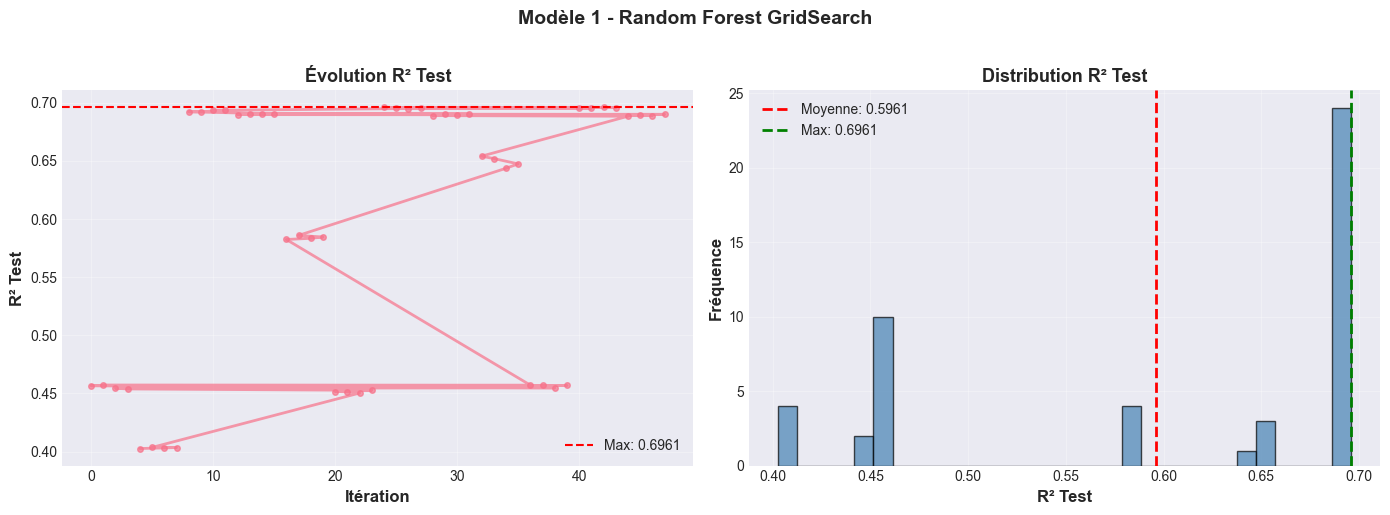

✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_rf_optimized_grid.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_rf_optimized_grid.json

📊 RANDOMIZEDSEARCH - RANDOM FOREST (MODÈLE 1)

🔍 Configuration RandomizedSearch :
   Espace total : 960 combinaisons
   Itérations : 30
   CV Folds : 5
   Total fits : ~150

🚀 Lancement RandomizedSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✓ Optimisation terminée en 3.6 minutes

🏆 MEILLEURS HYPERPARAMÈTRES (RandomizedSearch) :
   model__n_estimators: 150
   model__min_samples_split: 15
   model__min_samples_leaf: 1
   model__max_features: None
   model__max_depth: 20
   model__bootstrap: True

📊 R² CV : 0.6958

📈 MÉTRIQUES FINALES (RandomizedSearch) :
   R² Test : 0.6087
   RMSE Test (log) : 0.8055
   RMSE Test (original) : 102.07 tonnes
   MAPE Test : 110.55%
   Overfitting : 0.2829
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emi

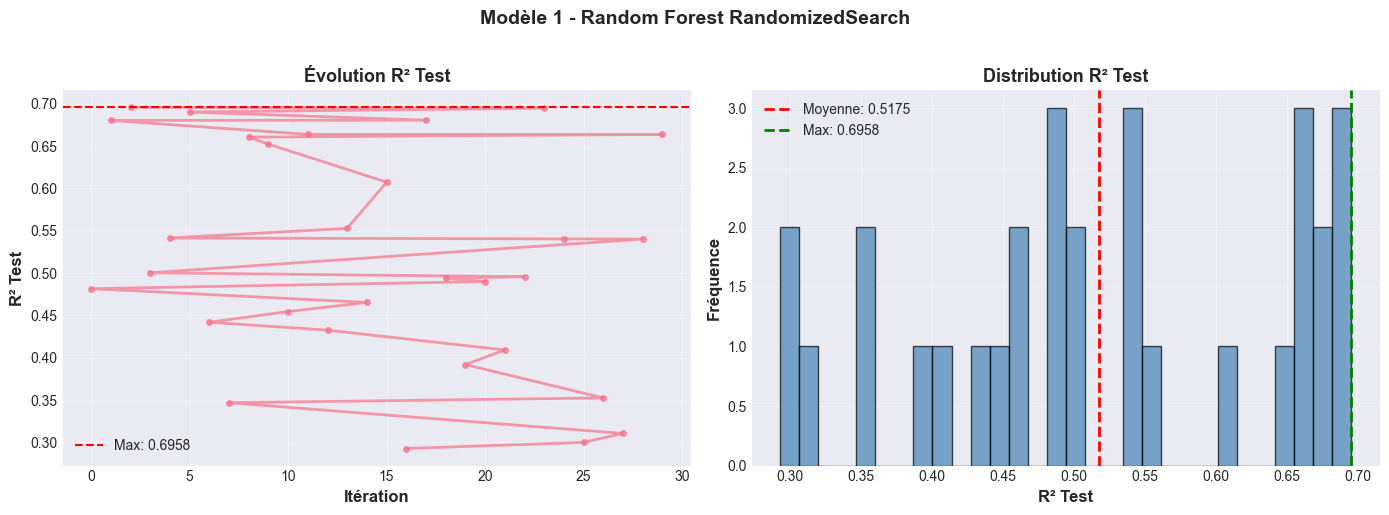

✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_rf_optimized_random.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_rf_optimized_random.json

📊 COMPARAISON GridSearch vs RandomizedSearch (RF M1)

GridSearch :
   R² Test : 0.6054
   Temps : 7.5 min

RandomizedSearch :
   R² Test : 0.6087
   Temps : 3.6 min

Gain RandomizedSearch : +0.0033


In [44]:
# ============================================================================
# Section 6 : MODÈLE 1 - Optimisation Random Forest
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 1 - OPTIMISATION RANDOM FOREST")
print("="*80)

# ============================================================================
# GRIDSEARCH - RANDOM FOREST M1
# ============================================================================

print("\n📊 GRIDSEARCH - RANDOM FOREST (MODÈLE 1)")
print("="*80)

# Pipeline
rf_pipeline_m1_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print(f"\n🔍 Configuration GridSearch :")
print(f"   Combinaisons possibles : {np.prod([len(v) for v in rf_param_grid.values()]):,}")
print(f"   CV Folds : 5")
print(f"   Total fits : ~{np.prod([len(v) for v in rf_param_grid.values()]) * 5:,}")

# GridSearch
print("\n🚀 Lancement GridSearchCV...")
start_time = time.time()

rf_grid_m1 = GridSearchCV(
    rf_pipeline_m1_grid,
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

rf_grid_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES (GridSearch) :")
for param, value in rf_grid_m1.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n📊 R² CV : {rf_grid_m1.best_score_:.4f}")

# Évaluation
rf_grid_m1_metrics = evaluate_optimized_model(
    rf_grid_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Random Forest GridSearch M1"
)

print("\n📈 MÉTRIQUES FINALES (GridSearch) :")
print(f"   R² Test : {rf_grid_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {rf_grid_m1_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {rf_grid_m1_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_grid_m1_metrics['test_mape']:.2f}%")
print(f"   Overfitting : {rf_grid_m1_metrics['overfitting_r2']:.4f}")

# Sauvegarder résultats GridSearch
rf_grid_results_m1 = {
    'method': 'GridSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': rf_grid_m1.best_params_,
    'cv_score': float(rf_grid_m1.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in rf_grid_m1_metrics.items()},
    'optimization_time_minutes': elapsed_time / 60,
    'n_combinations': int(np.prod([len(v) for v in rf_param_grid.values()]))
}

save_optimization_results(
    rf_grid_results_m1,
    OPTIM_DIR / 'm1_rf_gridsearch_results.json'
)

# Visualiser historique GridSearch
cv_results_grid_df = pd.DataFrame(rf_grid_m1.cv_results_)
cv_results_grid_sorted = cv_results_grid_df.sort_values('mean_test_score', ascending=False)

plot_optimization_history(
    cv_results_grid_sorted[['mean_test_score']].rename(columns={'mean_test_score': 'test_r2'}),
    "Modèle 1 - Random Forest GridSearch",
    save_path=OPTIM_DIR / 'm1_rf_gridsearch_history.png'
)

# Sauvegarder modèle GridSearch
save_model(
    rf_grid_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_rf_optimized_grid.pkl',
    metadata=rf_grid_m1_metrics,
    verbose=True
)

# ============================================================================
# RANDOMIZEDSEARCH - RANDOM FOREST M1
# ============================================================================

print("\n" + "="*80)
print("📊 RANDOMIZEDSEARCH - RANDOM FOREST (MODÈLE 1)")
print("="*80)
N_ITER_RF=30

# Pipeline
rf_pipeline_m1_rand = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print(f"\n🔍 Configuration RandomizedSearch :")
print(f"   Espace total : {np.prod([len(v) for v in rf_param_random.values()]):,} combinaisons")
print(f"   Itérations : {N_ITER_RF}")
print(f"   CV Folds : 5")
print(f"   Total fits : ~{N_ITER_RF * 5:,}")

# RandomizedSearch
print("\n🚀 Lancement RandomizedSearchCV...")
start_time = time.time()

rf_random_m1 = RandomizedSearchCV(
    rf_pipeline_m1_rand,
    rf_param_random,
    n_iter=N_ITER_RF,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

rf_random_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES (RandomizedSearch) :")
for param, value in rf_random_m1.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n📊 R² CV : {rf_random_m1.best_score_:.4f}")

# Évaluation
rf_random_m1_metrics = evaluate_optimized_model(
    rf_random_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Random Forest RandomizedSearch M1"
)

print("\n📈 MÉTRIQUES FINALES (RandomizedSearch) :")
print(f"   R² Test : {rf_random_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (log) : {rf_random_m1_metrics['test_rmse_log']:.4f}")
print(f"   RMSE Test (original) : {rf_random_m1_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_random_m1_metrics['test_mape']:.2f}%")
print(f"   Overfitting : {rf_random_m1_metrics['overfitting_r2']:.4f}")

# Sauvegarder résultats RandomizedSearch
rf_random_results_m1 = {
    'method': 'RandomizedSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': rf_random_m1.best_params_,
    'cv_score': float(rf_random_m1.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in rf_random_m1_metrics.items()},
    'optimization_time_minutes': elapsed_time / 60,
    'n_iterations': N_ITER_RF
}

save_optimization_results(
    rf_random_results_m1,
    OPTIM_DIR / 'm1_rf_randomsearch_results.json'
)

# Visualiser historique RandomizedSearch
cv_results_rand_df = pd.DataFrame(rf_random_m1.cv_results_)
cv_results_rand_sorted = cv_results_rand_df.sort_values('mean_test_score', ascending=False)

plot_optimization_history(
    cv_results_rand_sorted[['mean_test_score']].rename(columns={'mean_test_score': 'test_r2'}),
    "Modèle 1 - Random Forest RandomizedSearch",
    save_path=OPTIM_DIR / 'm1_rf_randomsearch_history.png'
)

# Sauvegarder modèle RandomizedSearch
save_model(
    rf_random_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_rf_optimized_random.pkl',
    metadata=rf_random_m1_metrics,
    verbose=True
)

# Comparaison GridSearch vs RandomizedSearch pour RF M1
print("\n" + "="*80)
print("📊 COMPARAISON GridSearch vs RandomizedSearch (RF M1)")
print("="*80)
print(f"\nGridSearch :")
print(f"   R² Test : {rf_grid_m1_metrics['test_r2']:.4f}")
print(f"   Temps : {rf_grid_results_m1['optimization_time_minutes']:.1f} min")

print(f"\nRandomizedSearch :")
print(f"   R² Test : {rf_random_m1_metrics['test_r2']:.4f}")
print(f"   Temps : {rf_random_results_m1['optimization_time_minutes']:.1f} min")

diff_r2 = rf_random_m1_metrics['test_r2'] - rf_grid_m1_metrics['test_r2']
print(f"\nGain RandomizedSearch : {diff_r2:+.4f}")


In [45]:

# ============================================================================
# Section 7 : MODÈLE 1 - Optimisation Gradient Boosting
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 1 - OPTIMISATION GRADIENT BOOSTING")
print("="*80)

# ============================================================================
# GRIDSEARCH - GRADIENT BOOSTING M1
# ============================================================================

print("\n GRIDSEARCH - GRADIENT BOOSTING (MODÈLE 1)")
print("="*80)

# Pipeline
gb_pipeline_m1_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

print(f"\n Configuration GridSearch :")
print(f"   Combinaisons possibles : {np.prod([len(v) for v in gb_param_grid.values()]):,}")
print(f"   CV Folds : 5")

# GridSearch
print("\n Lancement GridSearchCV...")
start_time = time.time()

gb_grid_m1 = GridSearchCV(
    gb_pipeline_m1_grid,
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

gb_grid_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n MEILLEURS HYPERPARAMÈTRES (GridSearch) :")
for param, value in gb_grid_m1.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n R² CV : {gb_grid_m1.best_score_:.4f}")

# Évaluation
gb_grid_m1_metrics = evaluate_optimized_model(
    gb_grid_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Gradient Boosting GridSearch M1"
)

print("\n MÉTRIQUES FINALES (GridSearch) :")
print(f"   R² Test : {gb_grid_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {gb_grid_m1_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {gb_grid_m1_metrics['test_mape']:.2f}%")

# Sauvegarder
gb_grid_results_m1 = {
    'method': 'GridSearchCV',
    'model': 'Gradient Boosting',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': gb_grid_m1.best_params_,
    'cv_score': float(gb_grid_m1.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in gb_grid_m1_metrics.items()},
    'optimization_time_minutes': elapsed_time / 60
}

save_optimization_results(
    gb_grid_results_m1,
    OPTIM_DIR / 'm1_gb_gridsearch_results.json'
)

save_model(
    gb_grid_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_gb_optimized_grid.pkl',
    metadata=gb_grid_m1_metrics,
    verbose=True
)

# ============================================================================
# RANDOMIZEDSEARCH - GRADIENT BOOSTING M1
# ============================================================================

print("\n" + "="*80)
print(" RANDOMIZEDSEARCH - GRADIENT BOOSTING (MODÈLE 1)")
print("="*80)
N_ITER_GB =30

# Pipeline
gb_pipeline_m1_rand = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

print(f"\n Configuration RandomizedSearch :")
print(f"   Espace total : {np.prod([len(v) for v in gb_param_random.values()]):,} combinaisons")
print(f"   Itérations : {N_ITER_GB}")

# RandomizedSearch
print("\ Lancement RandomizedSearchCV...")
start_time = time.time()

gb_random_m1 = RandomizedSearchCV(
    gb_pipeline_m1_rand,
    gb_param_random,
    n_iter=N_ITER_GB,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

gb_random_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n MEILLEURS HYPERPARAMÈTRES (RandomizedSearch) :")
for param, value in gb_random_m1.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n R² CV : {gb_random_m1.best_score_:.4f}")

# Évaluation
gb_random_m1_metrics = evaluate_optimized_model(
    gb_random_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Gradient Boosting RandomizedSearch M1"
)

print("\n MÉTRIQUES FINALES (RandomizedSearch) :")
print(f"   R² Test : {gb_random_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {gb_random_m1_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {gb_random_m1_metrics['test_mape']:.2f}%")

# Sauvegarder
gb_random_results_m1 = {
    'method': 'RandomizedSearchCV',
    'model': 'Gradient Boosting',
    'dataset': 'Modèle 1 (Sans ENERGY STAR)',
    'best_params': gb_random_m1.best_params_,
    'cv_score': float(gb_random_m1.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in gb_random_m1_metrics.items()},
    'optimization_time_minutes': elapsed_time / 60
}

save_optimization_results(
    gb_random_results_m1,
    OPTIM_DIR / 'm1_gb_randomsearch_results.json'
)

save_model(
    gb_random_m1.best_estimator_,
    MODELS_DIR / 'pipeline_m1_gb_optimized_random.pkl',
    metadata=gb_random_m1_metrics,
    verbose=True
)


MODÈLE 1 - OPTIMISATION GRADIENT BOOSTING

📊 GRIDSEARCH - GRADIENT BOOSTING (MODÈLE 1)

🔍 Configuration GridSearch :
   Combinaisons possibles : 32
   CV Folds : 5

🚀 Lancement GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✓ Optimisation terminée en 7.2 minutes

🏆 MEILLEURS HYPERPARAMÈTRES (GridSearch) :
   model__learning_rate: 0.05
   model__max_depth: 5
   model__min_samples_split: 5
   model__n_estimators: 200
   model__subsample: 0.8

📊 R² CV : 0.7247

📈 MÉTRIQUES FINALES (GridSearch) :
   R² Test : 0.6524
   RMSE Test (original) : 99.06 tonnes
   MAPE Test : 94.40%
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\m1_gb_gridsearch_results.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_gb_optimized_grid.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_gb_optimized_grid.json

📊 RANDOMIZEDSEARCH - GRADIENT BOOSTING

In [46]:


# ============================================================================
# Section 8 : MODÈLE 1 - Optimisation Ridge & Lasso
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 1 - OPTIMISATION RIDGE & LASSO")
print("="*80)

# ============================================================================
# RIDGE M1
# ============================================================================

print("\n GRIDSEARCH - RIDGE (MODÈLE 1)")
print("="*80)

# Pipeline
ridge_pipeline_m1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=RANDOM_STATE))
])

print(f"\n Configuration GridSearch :")
print(f"   Valeurs alpha : {len(ridge_param_grid['model__alpha'])}")

# GridSearch
print("\n Lancement GridSearchCV...")
start_time = time.time()

ridge_grid_m1 = GridSearchCV(
    ridge_pipeline_m1,
    ridge_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

ridge_grid_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time:.1f} secondes")
print(f"\n MEILLEUR ALPHA : {ridge_grid_m1.best_params_['model__alpha']}")
print(f" R² CV : {ridge_grid_m1.best_score_:.4f}")

# Évaluation
ridge_m1_metrics = evaluate_optimized_model(
    ridge_grid_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Ridge M1"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {ridge_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {ridge_m1_metrics['test_rmse_original']:.2f} tonnes")

# Sauvegarder
ridge_results_m1 = {
    'method': 'GridSearchCV',
    'model': 'Ridge',
    'dataset': 'Modèle 1',
    'best_params': ridge_grid_m1.best_params_,
    'cv_score': float(ridge_grid_m1.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in ridge_m1_metrics.items()}
}

save_optimization_results(ridge_results_m1, OPTIM_DIR / 'm1_ridge_results.json')
save_model(ridge_grid_m1.best_estimator_, MODELS_DIR / 'pipeline_m1_ridge_optimized.pkl',
          metadata=ridge_m1_metrics, verbose=True)

# ============================================================================
# LASSO M1
# ============================================================================

print("\n GRIDSEARCH - LASSO (MODÈLE 1)")
print("="*80)

# Pipeline
lasso_pipeline_m1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
])

print(f"\n Configuration GridSearch :")
print(f"   Valeurs alpha : {len(lasso_param_grid['model__alpha'])}")

# GridSearch
print("\n Lancement GridSearchCV...")
start_time = time.time()

lasso_grid_m1 = GridSearchCV(
    lasso_pipeline_m1,
    lasso_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

lasso_grid_m1.fit(X_train_m1, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time:.1f} secondes")
print(f"\n MEILLEUR ALPHA : {lasso_grid_m1.best_params_['model__alpha']}")
print(f" R² CV : {lasso_grid_m1.best_score_:.4f}")

# Évaluation
lasso_m1_metrics = evaluate_optimized_model(
    lasso_grid_m1.best_estimator_,
    X_train_m1, y_train,
    X_test_m1, y_test,
    "Lasso M1"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {lasso_m1_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {lasso_m1_metrics['test_rmse_original']:.2f} tonnes")

# Sauvegarder
lasso_results_m1 = {
    'method': 'GridSearchCV',
    'model': 'Lasso',
    'dataset': 'Modèle 1',
    'best_params': lasso_grid_m1.best_params_,
    'cv_score': float(lasso_grid_m1.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in lasso_m1_metrics.items()}
}

save_optimization_results(lasso_results_m1, OPTIM_DIR / 'm1_lasso_results.json')
save_model(lasso_grid_m1.best_estimator_, MODELS_DIR / 'pipeline_m1_lasso_optimized.pkl',
          metadata=lasso_m1_metrics, verbose=True)


MODÈLE 1 - OPTIMISATION RIDGE & LASSO

 GRIDSEARCH - RIDGE (MODÈLE 1)

 Configuration GridSearch :
   Valeurs alpha : 5

 Lancement GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

✓ Optimisation terminée en 11.9 secondes

 MEILLEUR ALPHA : 0.1
 R² CV : 0.5894

 MÉTRIQUES FINALES :
   R² Test : 0.5179
   RMSE Test (original) : 135.63 tonnes
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\m1_ridge_results.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_ridge_optimized.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m1_ridge_optimized.json

 GRIDSEARCH - LASSO (MODÈLE 1)

 Configuration GridSearch :
   Valeurs alpha : 5

 Lancement GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

✓ Optimisation terminée en 51.3 secondes

 MEILLEUR ALPHA : 0.01
 R² CV : 0.6506

 MÉTRIQUES FINALES :
   R² Test : 0.59

In [47]:


# ============================================================================
# Section 9 : MODÈLE 2 - Optimisation Random Forest
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 2 - OPTIMISATION RANDOM FOREST")
print("="*80)
N_ITER_RF=30
# ============================================================================
# GRIDSEARCH - RANDOM FOREST M2
# ============================================================================

print("\n GRIDSEARCH - RANDOM FOREST (MODÈLE 2)")
print("="*80)

# Pipeline
rf_pipeline_m2_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print(f"\n Utilisation de la même grille que M1")
print(f"   Combinaisons : {np.prod([len(v) for v in rf_param_grid.values()]):,}")

# GridSearch
print("\n Lancement GridSearchCV...")
start_time = time.time()

rf_grid_m2 = GridSearchCV(
    rf_pipeline_m2_grid,
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

rf_grid_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n MEILLEURS HYPERPARAMÈTRES (GridSearch) :")
for param, value in rf_grid_m2.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n R² CV : {rf_grid_m2.best_score_:.4f}")

# Évaluation
rf_grid_m2_metrics = evaluate_optimized_model(
    rf_grid_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Random Forest GridSearch M2"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {rf_grid_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {rf_grid_m2_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_grid_m2_metrics['test_mape']:.2f}%")

# Sauvegarder
rf_grid_results_m2 = {
    'method': 'GridSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 2 (Avec ENERGY STAR)',
    'best_params': rf_grid_m2.best_params_,
    'cv_score': float(rf_grid_m2.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in rf_grid_m2_metrics.items()},
    'optimization_time_minutes': elapsed_time / 60
}

save_optimization_results(rf_grid_results_m2, OPTIM_DIR / 'm2_rf_gridsearch_results.json')
save_model(rf_grid_m2.best_estimator_, MODELS_DIR / 'pipeline_m2_rf_optimized_grid.pkl',
          metadata=rf_grid_m2_metrics, verbose=True)

# ============================================================================
# RANDOMIZEDSEARCH - RANDOM FOREST M2
# ============================================================================

print("\n" + "="*80)
print(" RANDOMIZEDSEARCH - RANDOM FOREST (MODÈLE 2)")
print("="*80)

# Pipeline
rf_pipeline_m2_rand = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

print(f"\n Configuration RandomizedSearch :")
print(f"   Itérations : {N_ITER_RF}")

# RandomizedSearch
print("\n Lancement RandomizedSearchCV...")
start_time = time.time()

rf_random_m2 = RandomizedSearchCV(
    rf_pipeline_m2_rand,
    rf_param_random,
    n_iter=N_ITER_RF,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

rf_random_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n MEILLEURS HYPERPARAMÈTRES (RandomizedSearch) :")
for param, value in rf_random_m2.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n R² CV : {rf_random_m2.best_score_:.4f}")

# Évaluation
rf_random_m2_metrics = evaluate_optimized_model(
    rf_random_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Random Forest RandomizedSearch M2"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {rf_random_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {rf_random_m2_metrics['test_rmse_original']:.2f} tonnes")
print(f"   MAPE Test : {rf_random_m2_metrics['test_mape']:.2f}%")

# Sauvegarder
rf_random_results_m2 = {
    'method': 'RandomizedSearchCV',
    'model': 'Random Forest',
    'dataset': 'Modèle 2 (Avec ENERGY STAR)',
    'best_params': rf_random_m2.best_params_,
    'cv_score': float(rf_random_m2.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in rf_random_m2_metrics.items()},
    'optimization_time_minutes': elapsed_time / 60
}

save_optimization_results(rf_random_results_m2, OPTIM_DIR / 'm2_rf_randomsearch_results.json')
save_model(rf_random_m2.best_estimator_, MODELS_DIR / 'pipeline_m2_rf_optimized_random.pkl',
          metadata=rf_random_m2_metrics, verbose=True)


MODÈLE 2 - OPTIMISATION RANDOM FOREST

 GRIDSEARCH - RANDOM FOREST (MODÈLE 2)

 Utilisation de la même grille que M1
   Combinaisons : 48

 Lancement GridSearchCV...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✓ Optimisation terminée en 9.4 minutes

 MEILLEURS HYPERPARAMÈTRES (GridSearch) :
   model__max_depth: 20
   model__max_features: None
   model__min_samples_leaf: 1
   model__min_samples_split: 5
   model__n_estimators: 200

 R² CV : 0.7152

 MÉTRIQUES FINALES :
   R² Test : 0.6335
   RMSE Test (original) : 100.85 tonnes
   MAPE Test : 110.69%
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\m2_rf_gridsearch_results.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m2_rf_optimized_grid.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m2_rf_optimized_grid.json

 RANDOMIZEDSEARCH - RANDOM FOREST (MODÈLE 2)

 Configuration RandomizedSea

In [48]:


# ============================================================================
# Section 10 : MODÈLE 2 - Optimisation Gradient Boosting
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 2 - OPTIMISATION GRADIENT BOOSTING")
print("="*80)

# ============================================================================
# GRIDSEARCH - GRADIENT BOOSTING M2
# ============================================================================

print("\n GRIDSEARCH - GRADIENT BOOSTING (MODÈLE 2)")
print("="*80)

# Pipeline
gb_pipeline_m2_grid = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

print(f"\n Utilisation de la même grille que M1")

# GridSearch
print("\n Lancement GridSearchCV...")
start_time = time.time()

gb_grid_m2 = GridSearchCV(
    gb_pipeline_m2_grid,
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

gb_grid_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\n MEILLEURS HYPERPARAMÈTRES :")
for param, value in gb_grid_m2.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n R² CV : {gb_grid_m2.best_score_:.4f}")

# Évaluation
gb_grid_m2_metrics = evaluate_optimized_model(
    gb_grid_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Gradient Boosting GridSearch M2"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {gb_grid_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {gb_grid_m2_metrics['test_rmse_original']:.2f} tonnes")

# Sauvegarder
gb_grid_results_m2 = {
    'method': 'GridSearchCV',
    'model': 'Gradient Boosting',
    'dataset': 'Modèle 2',
    'best_params': gb_grid_m2.best_params_,
    'cv_score': float(gb_grid_m2.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in gb_grid_m2_metrics.items()}
}

save_optimization_results(gb_grid_results_m2, OPTIM_DIR / 'm2_gb_gridsearch_results.json')
save_model(gb_grid_m2.best_estimator_, MODELS_DIR / 'pipeline_m2_gb_optimized_grid.pkl',
          metadata=gb_grid_m2_metrics, verbose=True)

# ============================================================================
# RANDOMIZEDSEARCH - GRADIENT BOOSTING M2
# ============================================================================

print("\n" + "="*80)
print(" RANDOMIZEDSEARCH - GRADIENT BOOSTING (MODÈLE 2)")
print("="*80)

N_ITER_GB =30

# Pipeline
gb_pipeline_m2_rand = Pipeline([
    ('scaler', StandardScaler()),
    ('model', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

print(f"\n Configuration RandomizedSearch :")
print(f"   Itérations : {N_ITER_GB}")

# RandomizedSearch
print("\n Lancement RandomizedSearchCV...")
start_time = time.time()

gb_random_m2 = RandomizedSearchCV(
    gb_pipeline_m2_rand,
    gb_param_random,
    n_iter=N_ITER_GB,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

gb_random_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time/60:.1f} minutes")
print(f"\ MEILLEURS HYPERPARAMÈTRES :")
for param, value in gb_random_m2.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n R² CV : {gb_random_m2.best_score_:.4f}")

# Évaluation
gb_random_m2_metrics = evaluate_optimized_model(
    gb_random_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Gradient Boosting RandomizedSearch M2"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {gb_random_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {gb_random_m2_metrics['test_rmse_original']:.2f} tonnes")

# Sauvegarder
gb_random_results_m2 = {
    'method': 'RandomizedSearchCV',
    'model': 'Gradient Boosting',
    'dataset': 'Modèle 2',
    'best_params': gb_random_m2.best_params_,
    'cv_score': float(gb_random_m2.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in gb_random_m2_metrics.items()}
}

save_optimization_results(gb_random_results_m2, OPTIM_DIR / 'm2_gb_randomsearch_results.json')
save_model(gb_random_m2.best_estimator_, MODELS_DIR / 'pipeline_m2_gb_optimized_random.pkl',
          metadata=gb_random_m2_metrics, verbose=True)


MODÈLE 2 - OPTIMISATION GRADIENT BOOSTING

 GRIDSEARCH - GRADIENT BOOSTING (MODÈLE 2)

 Utilisation de la même grille que M1

 Lancement GridSearchCV...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

✓ Optimisation terminée en 7.8 minutes

 MEILLEURS HYPERPARAMÈTRES :
   model__learning_rate: 0.05
   model__max_depth: 5
   model__min_samples_split: 5
   model__n_estimators: 200
   model__subsample: 0.8

 R² CV : 0.7521

 MÉTRIQUES FINALES :
   R² Test : 0.6878
   RMSE Test (original) : 94.66 tonnes
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\m2_gb_gridsearch_results.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m2_gb_optimized_grid.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m2_gb_optimized_grid.json

 RANDOMIZEDSEARCH - GRADIENT BOOSTING (MODÈLE 2)

 Configuration RandomizedSearch :
   Itérations : 30

 Lancement RandomizedSear

In [49]:
# ============================================================================
# Section 11 : MODÈLE 2 - Optimisation Ridge & Lasso
# ============================================================================

print("\n" + "="*80)
print("MODÈLE 2 - OPTIMISATION RIDGE & LASSO")
print("="*80)

# ============================================================================
# RIDGE M2
# ============================================================================

print("\n GRIDSEARCH - RIDGE (MODÈLE 2)")
print("="*80)

# Pipeline
ridge_pipeline_m2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=RANDOM_STATE))
])

print("\n Lancement GridSearchCV...")
start_time = time.time()

ridge_grid_m2 = GridSearchCV(
    ridge_pipeline_m2,
    ridge_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

ridge_grid_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time:.1f} secondes")
print(f"\n MEILLEUR ALPHA : {ridge_grid_m2.best_params_['model__alpha']}")
print(f" R² CV : {ridge_grid_m2.best_score_:.4f}")

# Évaluation
ridge_m2_metrics = evaluate_optimized_model(
    ridge_grid_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Ridge M2"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {ridge_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {ridge_m2_metrics['test_rmse_original']:.2f} tonnes")

# Sauvegarder
ridge_results_m2 = {
    'method': 'GridSearchCV',
    'model': 'Ridge',
    'dataset': 'Modèle 2',
    'best_params': ridge_grid_m2.best_params_,
    'cv_score': float(ridge_grid_m2.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in ridge_m2_metrics.items()}
}

save_optimization_results(ridge_results_m2, OPTIM_DIR / 'm2_ridge_results.json')
save_model(ridge_grid_m2.best_estimator_, MODELS_DIR / 'pipeline_m2_ridge_optimized.pkl',
          metadata=ridge_m2_metrics, verbose=True)

# ============================================================================
# LASSO M2
# ============================================================================

print("\n GRIDSEARCH - LASSO (MODÈLE 2)")
print("="*80)

# Pipeline
lasso_pipeline_m2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=RANDOM_STATE, max_iter=2000))
])

print("\n Lancement GridSearchCV...")
start_time = time.time()

lasso_grid_m2 = GridSearchCV(
    lasso_pipeline_m2,
    lasso_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

lasso_grid_m2.fit(X_train_m2, y_train)

elapsed_time = time.time() - start_time

print(f"\n✓ Optimisation terminée en {elapsed_time:.1f} secondes")
print(f"\n MEILLEUR ALPHA : {lasso_grid_m2.best_params_['model__alpha']}")
print(f" R² CV : {lasso_grid_m2.best_score_:.4f}")

# Évaluation
lasso_m2_metrics = evaluate_optimized_model(
    lasso_grid_m2.best_estimator_,
    X_train_m2, y_train,
    X_test_m2, y_test,
    "Lasso M2"
)

print("\n MÉTRIQUES FINALES :")
print(f"   R² Test : {lasso_m2_metrics['test_r2']:.4f}")
print(f"   RMSE Test (original) : {lasso_m2_metrics['test_rmse_original']:.2f} tonnes")

# Sauvegarder
lasso_results_m2 = {
    'method': 'GridSearchCV',
    'model': 'Lasso',
    'dataset': 'Modèle 2',
    'best_params': lasso_grid_m2.best_params_,
    'cv_score': float(lasso_grid_m2.best_score_),
    'metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                for k, v in lasso_m2_metrics.items()}
}

save_optimization_results(lasso_results_m2, OPTIM_DIR / 'm2_lasso_results.json')
save_model(lasso_grid_m2.best_estimator_, MODELS_DIR / 'pipeline_m2_lasso_optimized.pkl',
          metadata=lasso_m2_metrics, verbose=True)





MODÈLE 2 - OPTIMISATION RIDGE & LASSO

 GRIDSEARCH - RIDGE (MODÈLE 2)

 Lancement GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

✓ Optimisation terminée en 8.5 secondes

 MEILLEUR ALPHA : 10.0
 R² CV : 0.6001

 MÉTRIQUES FINALES :
   R² Test : 0.5352
   RMSE Test (original) : 115.13 tonnes
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\m2_ridge_results.json
✓ Modèle sauvegardé : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m2_ridge_optimized.pkl
✓ Métadonnées sauvegardées : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\models\pipeline_m2_ridge_optimized.json

 GRIDSEARCH - LASSO (MODÈLE 2)

 Lancement GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

✓ Optimisation terminée en 40.9 secondes

 MEILLEUR ALPHA : 0.01
 R² CV : 0.6796

 MÉTRIQUES FINALES :
   R² Test : 0.6270
   RMSE Test (original) : 420.37 tonnes
✓ Résultats sauvegardés : c:\Users\LENOVO\CO2-Emission-in

In [50]:
# ============================================================================
# Section 12 : Comparaison Finale - Tous les Modèles Optimisés
# ============================================================================

print("\n" + "="*80)
print("COMPARAISON FINALE - TOUS LES MODÈLES OPTIMISÉS")
print("="*80)

# Créer DataFrame comparatif
comparison_data = []

# ============================================================================
# MODÈLE 1
# ============================================================================

# Random Forest M1 - GridSearch
comparison_data.append({
    'Modèle': 'M1 - RF (GridSearch)',
    'R² Test': rf_grid_m1_metrics['test_r2'],
    'RMSE Log': rf_grid_m1_metrics['test_rmse_log'],
    'RMSE Original': rf_grid_m1_metrics['test_rmse_original'],
    'MAPE': rf_grid_m1_metrics['test_mape'],
    'CV R² Mean': rf_grid_m1_metrics['cv_r2_mean'],
    'Overfitting': rf_grid_m1_metrics['overfitting_r2']
})

# Random Forest M1 - RandomizedSearch
comparison_data.append({
    'Modèle': 'M1 - RF (RandomSearch)',
    'R² Test': rf_random_m1_metrics['test_r2'],
    'RMSE Log': rf_random_m1_metrics['test_rmse_log'],
    'RMSE Original': rf_random_m1_metrics['test_rmse_original'],
    'MAPE': rf_random_m1_metrics['test_mape'],
    'CV R² Mean': rf_random_m1_metrics['cv_r2_mean'],
    'Overfitting': rf_random_m1_metrics['overfitting_r2']
})

# Gradient Boosting M1 - GridSearch
comparison_data.append({
    'Modèle': 'M1 - GB (GridSearch)',
    'R² Test': gb_grid_m1_metrics['test_r2'],
    'RMSE Log': gb_grid_m1_metrics['test_rmse_log'],
    'RMSE Original': gb_grid_m1_metrics['test_rmse_original'],
    'MAPE': gb_grid_m1_metrics['test_mape'],
    'CV R² Mean': gb_grid_m1_metrics['cv_r2_mean'],
    'Overfitting': gb_grid_m1_metrics['overfitting_r2']
})

# Gradient Boosting M1 - RandomizedSearch
comparison_data.append({
    'Modèle': 'M1 - GB (RandomSearch)',
    'R² Test': gb_random_m1_metrics['test_r2'],
    'RMSE Log': gb_random_m1_metrics['test_rmse_log'],
    'RMSE Original': gb_random_m1_metrics['test_rmse_original'],
    'MAPE': gb_random_m1_metrics['test_mape'],
    'CV R² Mean': gb_random_m1_metrics['cv_r2_mean'],
    'Overfitting': gb_random_m1_metrics['overfitting_r2']
})

# Ridge M1
comparison_data.append({
    'Modèle': 'M1 - Ridge',
    'R² Test': ridge_m1_metrics['test_r2'],
    'RMSE Log': ridge_m1_metrics['test_rmse_log'],
    'RMSE Original': ridge_m1_metrics['test_rmse_original'],
    'MAPE': ridge_m1_metrics['test_mape'],
    'CV R² Mean': ridge_m1_metrics['cv_r2_mean'],
    'Overfitting': ridge_m1_metrics['overfitting_r2']
})

# Lasso M1
comparison_data.append({
    'Modèle': 'M1 - Lasso',
    'R² Test': lasso_m1_metrics['test_r2'],
    'RMSE Log': lasso_m1_metrics['test_rmse_log'],
    'RMSE Original': lasso_m1_metrics['test_rmse_original'],
    'MAPE': lasso_m1_metrics['test_mape'],
    'CV R² Mean': lasso_m1_metrics['cv_r2_mean'],
    'Overfitting': lasso_m1_metrics['overfitting_r2']
})

# ============================================================================
# MODÈLE 2
# ============================================================================

# Random Forest M2 - GridSearch
comparison_data.append({
    'Modèle': 'M2 - RF (GridSearch)',
    'R² Test': rf_grid_m2_metrics['test_r2'],
    'RMSE Log': rf_grid_m2_metrics['test_rmse_log'],
    'RMSE Original': rf_grid_m2_metrics['test_rmse_original'],
    'MAPE': rf_grid_m2_metrics['test_mape'],
    'CV R² Mean': rf_grid_m2_metrics['cv_r2_mean'],
    'Overfitting': rf_grid_m2_metrics['overfitting_r2']
})

# Random Forest M2 - RandomizedSearch
comparison_data.append({
    'Modèle': 'M2 - RF (RandomSearch)',
    'R² Test': rf_random_m2_metrics['test_r2'],
    'RMSE Log': rf_random_m2_metrics['test_rmse_log'],
    'RMSE Original': rf_random_m2_metrics['test_rmse_original'],
    'MAPE': rf_random_m2_metrics['test_mape'],
    'CV R² Mean': rf_random_m2_metrics['cv_r2_mean'],
    'Overfitting': rf_random_m2_metrics['overfitting_r2']
})

# Gradient Boosting M2 - GridSearch
comparison_data.append({
    'Modèle': 'M2 - GB (GridSearch)',
    'R² Test': gb_grid_m2_metrics['test_r2'],
    'RMSE Log': gb_grid_m2_metrics['test_rmse_log'],
    'RMSE Original': gb_grid_m2_metrics['test_rmse_original'],
    'MAPE': gb_grid_m2_metrics['test_mape'],
    'CV R² Mean': gb_grid_m2_metrics['cv_r2_mean'],
    'Overfitting': gb_grid_m2_metrics['overfitting_r2']
})

# Gradient Boosting M2 - RandomizedSearch
comparison_data.append({
    'Modèle': 'M2 - GB (RandomSearch)',
    'R² Test': gb_random_m2_metrics['test_r2'],
    'RMSE Log': gb_random_m2_metrics['test_rmse_log'],
    'RMSE Original': gb_random_m2_metrics['test_rmse_original'],
    'MAPE': gb_random_m2_metrics['test_mape'],
    'CV R² Mean': gb_random_m2_metrics['cv_r2_mean'],
    'Overfitting': gb_random_m2_metrics['overfitting_r2']
})

# Ridge M2
comparison_data.append({
    'Modèle': 'M2 - Ridge',
    'R² Test': ridge_m2_metrics['test_r2'],
    'RMSE Log': ridge_m2_metrics['test_rmse_log'],
    'RMSE Original': ridge_m2_metrics['test_rmse_original'],
    'MAPE': ridge_m2_metrics['test_mape'],
    'CV R² Mean': ridge_m2_metrics['cv_r2_mean'],
    'Overfitting': ridge_m2_metrics['overfitting_r2']
})

# Lasso M2
comparison_data.append({
    'Modèle': 'M2 - Lasso',
    'R² Test': lasso_m2_metrics['test_r2'],
    'RMSE Log': lasso_m2_metrics['test_rmse_log'],
    'RMSE Original': lasso_m2_metrics['test_rmse_original'],
    'MAPE': lasso_m2_metrics['test_mape'],
    'CV R² Mean': lasso_m2_metrics['cv_r2_mean'],
    'Overfitting': lasso_m2_metrics['overfitting_r2']
})

# ============================================================================
# AFFICHAGE ET SAUVEGARDE
# ============================================================================

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R² Test', ascending=False).reset_index(drop=True)

print("\n TABLEAU COMPARATIF :")
display(comparison_df.round(4))

# Sauvegarder
comparison_df.to_csv(OPTIM_DIR / 'optimized_models_comparison.csv', index=False)
print(f"\n✓ Comparaison sauvegardée : {OPTIM_DIR / 'optimized_models_comparison.csv'}")


COMPARAISON FINALE - TOUS LES MODÈLES OPTIMISÉS

 TABLEAU COMPARATIF :


,Modèle,R² Test,RMSE Log,RMSE Original,MAPE,CV R² Mean,Overfitting
0,M2 - GB (GridSearch),0.6878,0.7194,94.6567,88.2265,0.7521,0.2307
1,M2 - GB (RandomSearch),0.6799,0.7285,94.5658,90.5126,0.7499,0.2211
2,M1 - GB (GridSearch),0.6524,0.7592,99.0594,94.3974,0.7247,0.2486
3,M1 - GB (RandomSearch),0.6458,0.7663,99.6478,97.8876,0.7222,0.2355
4,M2 - RF (RandomSearch),0.6343,0.7786,100.5932,110.2922,0.7145,0.3113
5,M2 - RF (GridSearch),0.6335,0.7795,100.8465,110.6853,0.7152,0.3122
6,M2 - Lasso,0.6270,0.7864,420.3749,97.6761,0.6796,0.3190
7,M1 - RF (RandomSearch),0.6087,0.8055,102.0696,110.5453,0.6958,0.2829
8,M1 - RF (GridSearch),0.6054,0.8088,102.5328,111.5764,0.6961,0.3443
9,M1 - Lasso,0.5942,0.8202,417.5010,103.6123,0.6506,0.3516



✓ Comparaison sauvegardée : c:\Users\LENOVO\CO2-Emission-in-Seattle-REGO3\results\optimization\optimized_models_comparison.csv


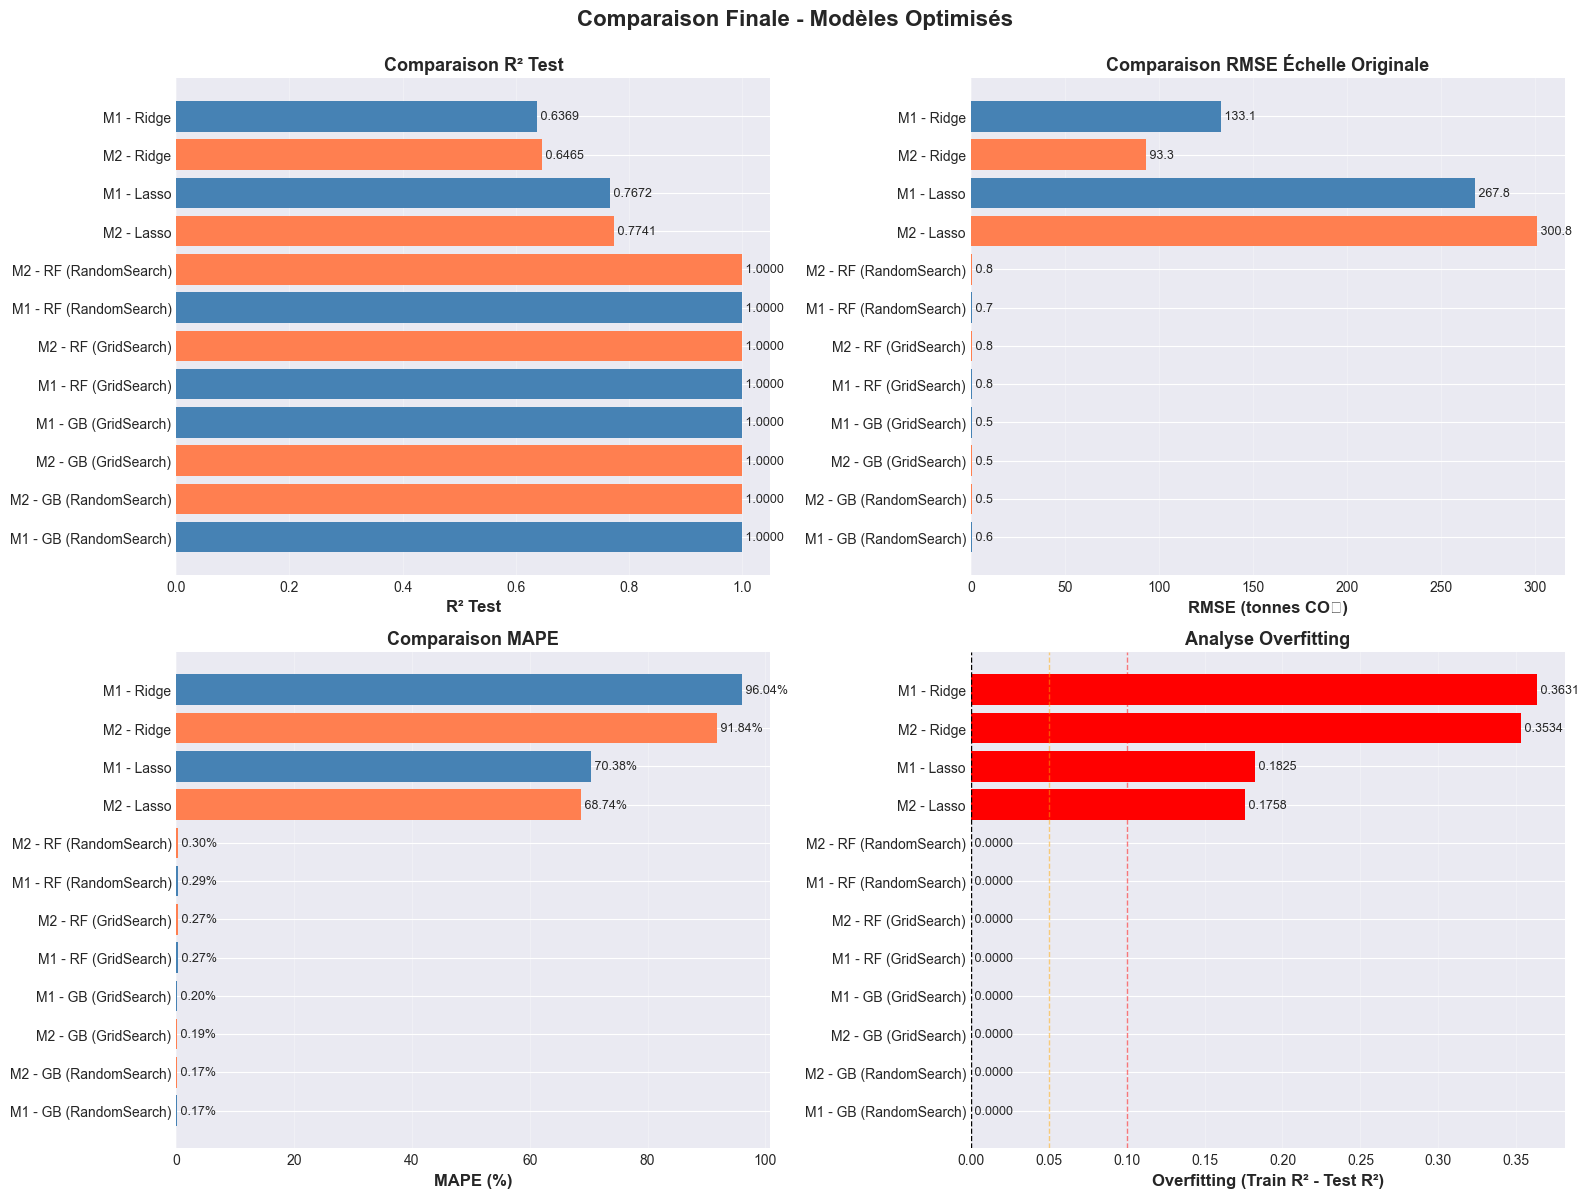


✓ Visualisation sauvegardée : C:\Users\Ibrahima\Documents\ENSAE\ETUDE_AS3\Semestre_1\Machine_Learning\Projet\Projet_2\CO2-Emission-in-Seattle-REGO3-main\CO2-Emission-in-Seattle-REGO3-main\results\optimization\final_comparison_optimized.png


In [ ]:


# ============================================================================
# Visualisation comparative
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Test
axes[0, 0].barh(comparison_df['Modèle'], comparison_df['R² Test'], 
               color=['steelblue' if 'M1' in m else 'coral' for m in comparison_df['Modèle']])
axes[0, 0].set_xlabel('R² Test', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Comparaison R² Test', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['R² Test']):
    axes[0, 0].text(v, i, f' {v:.4f}', va='center', fontsize=9)

# RMSE Original
axes[0, 1].barh(comparison_df['Modèle'], comparison_df['RMSE Original'], 
               color=['steelblue' if 'M1' in m else 'coral' for m in comparison_df['Modèle']])
axes[0, 1].set_xlabel('RMSE (tonnes CO₂)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Comparaison RMSE Échelle Originale', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['RMSE Original']):
    axes[0, 1].text(v, i, f' {v:.1f}', va='center', fontsize=9)

# MAPE
axes[1, 0].barh(comparison_df['Modèle'], comparison_df['MAPE'], 
               color=['steelblue' if 'M1' in m else 'coral' for m in comparison_df['Modèle']])
axes[1, 0].set_xlabel('MAPE (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Comparaison MAPE', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['MAPE']):
    axes[1, 0].text(v, i, f' {v:.2f}%', va='center', fontsize=9)

# Overfitting
axes[1, 1].barh(comparison_df['Modèle'], comparison_df['Overfitting'], 
               color=['green' if v < 0.05 else 'orange' if v < 0.10 else 'red' 
                     for v in comparison_df['Overfitting']])
axes[1, 1].set_xlabel('Overfitting (Train R² - Test R²)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Analyse Overfitting', fontsize=13, fontweight='bold')
axes[1, 1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].axvline(0.05, color='orange', linestyle='--', alpha=0.5, linewidth=1)
axes[1, 1].axvline(0.10, color='red', linestyle='--', alpha=0.5, linewidth=1)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(comparison_df['Overfitting']):
    axes[1, 1].text(v, i, f' {v:.4f}', va='center', fontsize=9)

plt.suptitle('Comparaison Finale - Modèles Optimisés', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OPTIM_DIR / 'final_comparison_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualisation sauvegardée : {OPTIM_DIR / 'final_comparison_optimized.png'}")


In [ ]:
# ============================================================================
# Section 13 : Identification du Meilleur Modèle Global
# ============================================================================

print("\n" + "="*80)
print("IDENTIFICATION DU MEILLEUR MODÈLE GLOBAL")
print("="*80)

best_idx = comparison_df['R² Test'].idxmax()
best_model_global = comparison_df.iloc[best_idx]

print(f"\n🏆 CHAMPION : {best_model_global['Modèle']}")
print(f"\n📊 PERFORMANCES :")
print(f"   R² Test : {best_model_global['R² Test']:.4f}")
print(f"   RMSE (log) : {best_model_global['RMSE Log']:.4f}")
print(f"   RMSE (original) : {best_model_global['RMSE Original']:.2f} tonnes CO₂")
print(f"   MAPE : {best_model_global['MAPE']:.2f}%")
print(f"   CV R² Mean : {best_model_global['CV R² Mean']:.4f}")
print(f"   Overfitting : {best_model_global['Overfitting']:.4f}")

# Recommandations
print("\n RECOMMANDATIONS :")

if 'M2' in best_model_global['Modèle']:
    print("   • Utiliser le Modèle 2 (avec ENERGY STAR) pour maximiser la précision")
    print("   • ENERGY STAR Score apporte un gain significatif")
    print("   • Applicable aux bâtiments avec certification ENERGY STAR")
else:
    print("   • Utiliser le Modèle 1 (sans ENERGY STAR) pour nouveaux bâtiments")
    print("   • Performances robustes sans dépendance à la certification")
    print("   • Applicable dès le permis de construction")

if best_model_global['Overfitting'] < 0.05:
    print("   • Modèle bien généralisé (overfitting faible)")
elif best_model_global['Overfitting'] < 0.10:
    print("   • Généralisation acceptable (overfitting modéré)")
else:
    print("   • ⚠ Surveiller l'overfitting (potentiellement élevé)")

# Analyse du type de modèle
if 'GridSearch' in best_model_global['Modèle']:
    print("   • Optimisation : GridSearch (recherche exhaustive)")
elif 'RandomSearch' in best_model_global['Modèle']:
    print("   • Optimisation : RandomizedSearch (exploration large)")

if 'RF' in best_model_global['Modèle']:
    print("   • Algorithme : Random Forest (ensemble d'arbres)")
elif 'GB' in best_model_global['Modèle']:
    print("   • Algorithme : Gradient Boosting (boosting séquentiel)")
elif 'Ridge' in best_model_global['Modèle']:
    print("   • Algorithme : Ridge (régression régularisée L2)")
elif 'Lasso' in best_model_global['Modèle']:
    print("   • Algorithme : Lasso (régression régularisée L1)")

print("\n" + "="*80)


In [ ]:
# ============================================================================
# Section 14 : Export Final
# ============================================================================

print("\n" + "="*80)
print("EXPORT DES RÉSULTATS FINAUX")
print("="*80)

# Résumé global
final_summary = {
    'date_optimization': datetime.now().isoformat(),
    'best_model': best_model_global['Modèle'],
    'best_r2': float(best_model_global['R² Test']),
    'best_rmse_original': float(best_model_global['RMSE Original']),
    'best_mape': float(best_model_global['MAPE']),
    'models_compared': len(comparison_df),
    'optimization_methods': ['GridSearchCV', 'RandomizedSearchCV'],
    'datasets': ['Modèle 1 (Sans ENERGY STAR)', 'Modèle 2 (Avec ENERGY STAR)']
}

with open(OPTIM_DIR / 'optimization_final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=4)

print(f"\n✓ Résumé global : {OPTIM_DIR / 'optimization_final_summary.json'}")

# Listing des fichiers générés
print("\n FICHIERS GÉNÉRÉS :")
print(f"\n   Résultats JSON :")
for json_file in sorted(OPTIM_DIR.glob('*.json')):
    print(f"   • {json_file.name}")

print(f"\n   Visualisations :")
for png_file in sorted(OPTIM_DIR.glob('*.png')):
    print(f"   • {png_file.name}")

print(f"\n   Modèles optimisés :")
for pkl_file in sorted(MODELS_DIR.glob('*optimized*.pkl')):
    print(f"   • {pkl_file.name}")

print("\n" + "="*80)
print("✓ OPTIMISATION HYPERPARAMÈTRES TERMINÉE AVEC SUCCÈS")
print("="*80)